# **SpaceShip Titanic**
宇宙船タイタニック号データセットによる二値分類。\
宇宙船が時空異常と衝突したときに乗客が別の次元に飛ばされたか予測。\
データ解析、特徴エンジニアリング、データクリーニング、
エンコーディング、スケーリング、前処理、モデル、
交差検証、アンサンブル

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=7bd8d29e954b9cae4e1d3dfb7523425de41418f88e37d60970fdaa5f3f441fb7
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
# Core
import pandas as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=44bbb2b15139c1e125eb2f03d10aa8a705ad94ec25cc01ee4b626cd85f01eaf3
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib


In [ ]:
import japanize_matplotlib

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, roc_curve

# Data 
trainとtestに分割\
trainにtransportedが入っている。\
train(X_train,y_train), test(X_test)に今後分ける。\
transported:True輸送された

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spaceship/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spaceship/test.csv')
print('train shape', train.shape)
print('test shape', test.shape)
train.head()

train shape (8693, 14)
test shape (4277, 13)


PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

*Feature descriptions:*
> * **PassengerId** - 各乗客の ID。各IDはgggg_ppの形式を取り、ggggは乗客が一緒に旅行しているグループを示し、ppはグループ内の番号。グループ内の多くの場合家族だが、例外もある。
> * **HomePlanet** - 乗客が出発した惑星、通常は永住権の惑星。(Europa, Earth, Mars)
> * **CryoSleep** - 乗客が凍結睡眠を選択したかどうかを示す。凍結中の乗客は閉じ込められている。
> * **Cabin** - 乗客が滞在しているキャビン番号。デッキ/数/サイドの形式を取り、サイドは左舷の場合はP、右舷の場合はSのいずれか。
> * **Destination** - 乗客が上陸させられた惑星。
> * **Age** - 年齢
> * **VIP** - 乗客が航海中に特別なVIPサービスの料金を支払ったかどうか。
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - 乗客がスペースシップタイタニック号の多くの豪華な設備のそれぞれで請求した金額。
> * **Name** - 名前
> * **Transported** - 乗客が別の次元に輸送されたかどうか。これはターゲットであり、予測しようとしている列。True輸送された

**欠損値**

In [ ]:
print('Train missing values')
print(train.isna().sum())
print('Test missing values')
print(test.isna().sum())

Train missing values
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Test missing values
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


**特徴量の重複確認**\
重複行を抽出

In [ ]:
print('Duplicates in train', train.duplicated().sum())
print('Duplicates in test', test.duplicated().sum())

Duplicates in train 0
Duplicates in test 0


**trainのuniqueな要素数**

In [ ]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

**Data types**

In [ ]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

objectはint,floatに変換

#EDAデータ理解


exp_featsの対数変換

In [ ]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [ ]:
train[exp_feats]

RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
0             0.0        0.0           0.0     0.0     0.0
1           109.0        9.0          25.0   549.0    44.0
2            43.0     3576.0           0.0  6715.0    49.0
3             0.0     1283.0         371.0  3329.0   193.0
4           303.0       70.0         151.0   565.0     2.0
...           ...        ...           ...     ...     ...
8688          0.0     6819.0           0.0  1643.0    74.0
8689          0.0        0.0           0.0     0.0     0.0
8690          0.0        0.0        1872.0     1.0     0.0
8691          0.0     1049.0           0.0   353.0  3235.0
8692        126.0     4688.0           0.0     0.0    12.0

[8693 rows x 5 columns]

<Axes: >

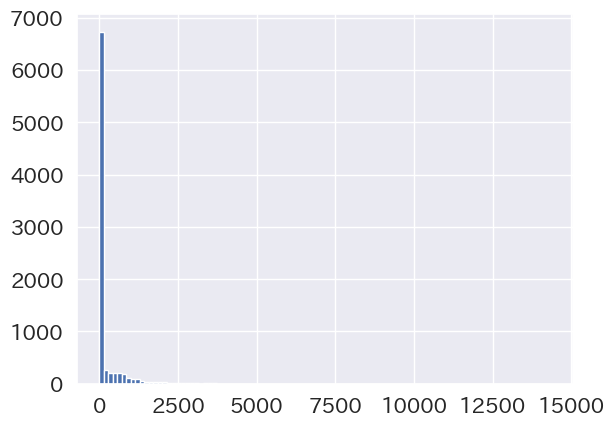

In [ ]:
from scipy import stats
rc_log = stats.boxcox(train['RoomService']+1, lmbda=0)
rc_bc, bc_params = stats.boxcox(train['RoomService']+1)
train['rc_log'] = rc_bc
train['RoomService'].hist(bins=100)

Text(0.5, 1.0, 'ShoppingMall')

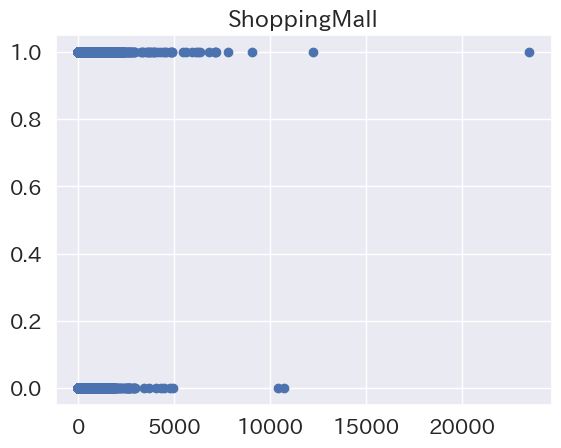

In [ ]:
fig, ax = plt.subplots()
ax.scatter(train['ShoppingMall'], train['Transported'])
ax.set_title('ShoppingMall')

In [ ]:
'''fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(exp_feats):
    ax=fig.add_subplot(4,1,i+1)
    ax.scatter(train[exp_feats][i], train['Transported'])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()'''

"fig=plt.figure(figsize=(10,16))\nfor i, var_name in enumerate(exp_feats):\n    ax=fig.add_subplot(4,1,i+1)\n    ax.scatter(train[exp_feats][i], train['Transported'])\n    ax.set_title(var_name)\nfig.tight_layout()  # Improves appearance a bit\nplt.show()"

Text(0.5, 1.0, 'Target distribution')

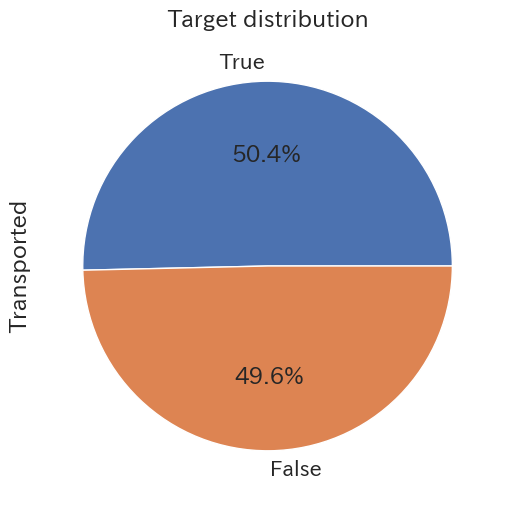

In [ ]:
plt.figure(figsize=(6, 6))
train['Transported'].value_counts().plot.pie(autopct='%1.1f%%').set_title('Target distribution')

targetは非常にバランスが取れているため、under/over samplingなどはしなくていい。

Text(0.5, 0, 'Age')

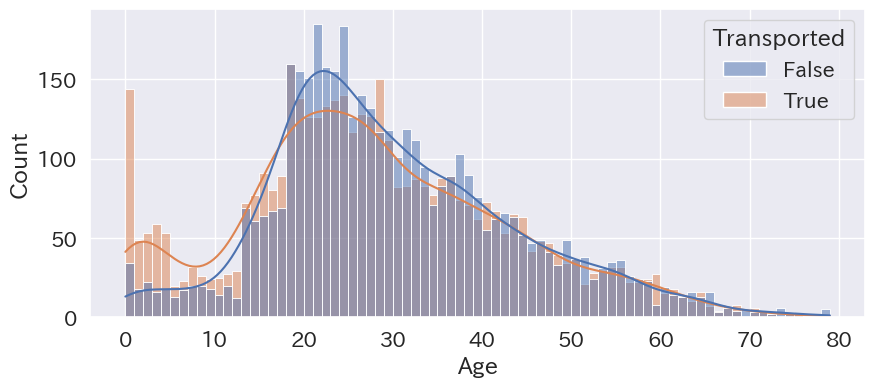

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title=('Age分布')
plt.xlabel('Age')

*0-18は輸送される可能性高い\
*18-25は可能性低い\
*25以上はどちらも同じくらい\

乗客が子供、青年、大人を示す新しい特徴量を作成する必要あり


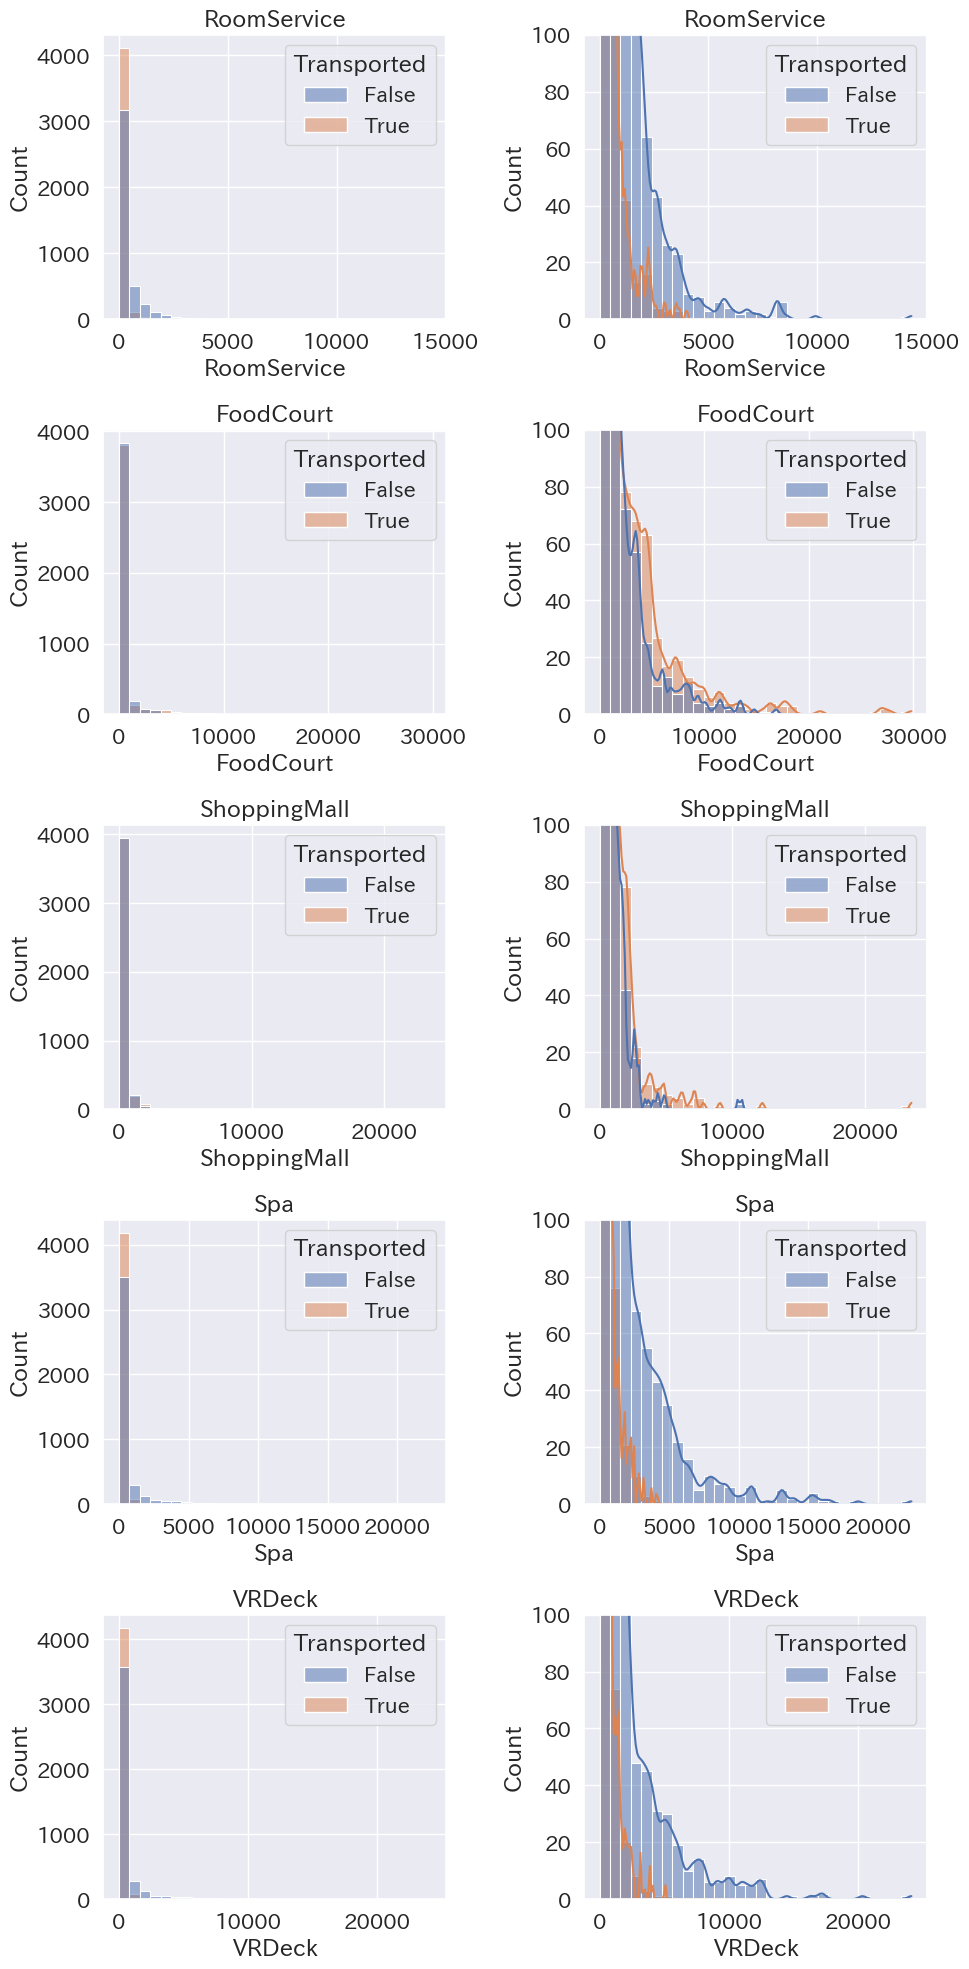

In [ ]:
# Plot expenditure features
fig=plt.figure(figsize=(10,20))

for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

*ほとんどの人はお金を使わない(左より）\
*支出分布（右）は指数関数的に減少\
*外れ値が小数
*輸送された人々(赤）はより少ない支出をする傾向。\
*ルームサービス、スパ、VRDeckはフードコート、ショッピングモールとは異なる分析結果になっている。贅沢設備と不可欠設備と考えられる。\

5つの施設すべての総支出を見る新しい特徴量を作成する。

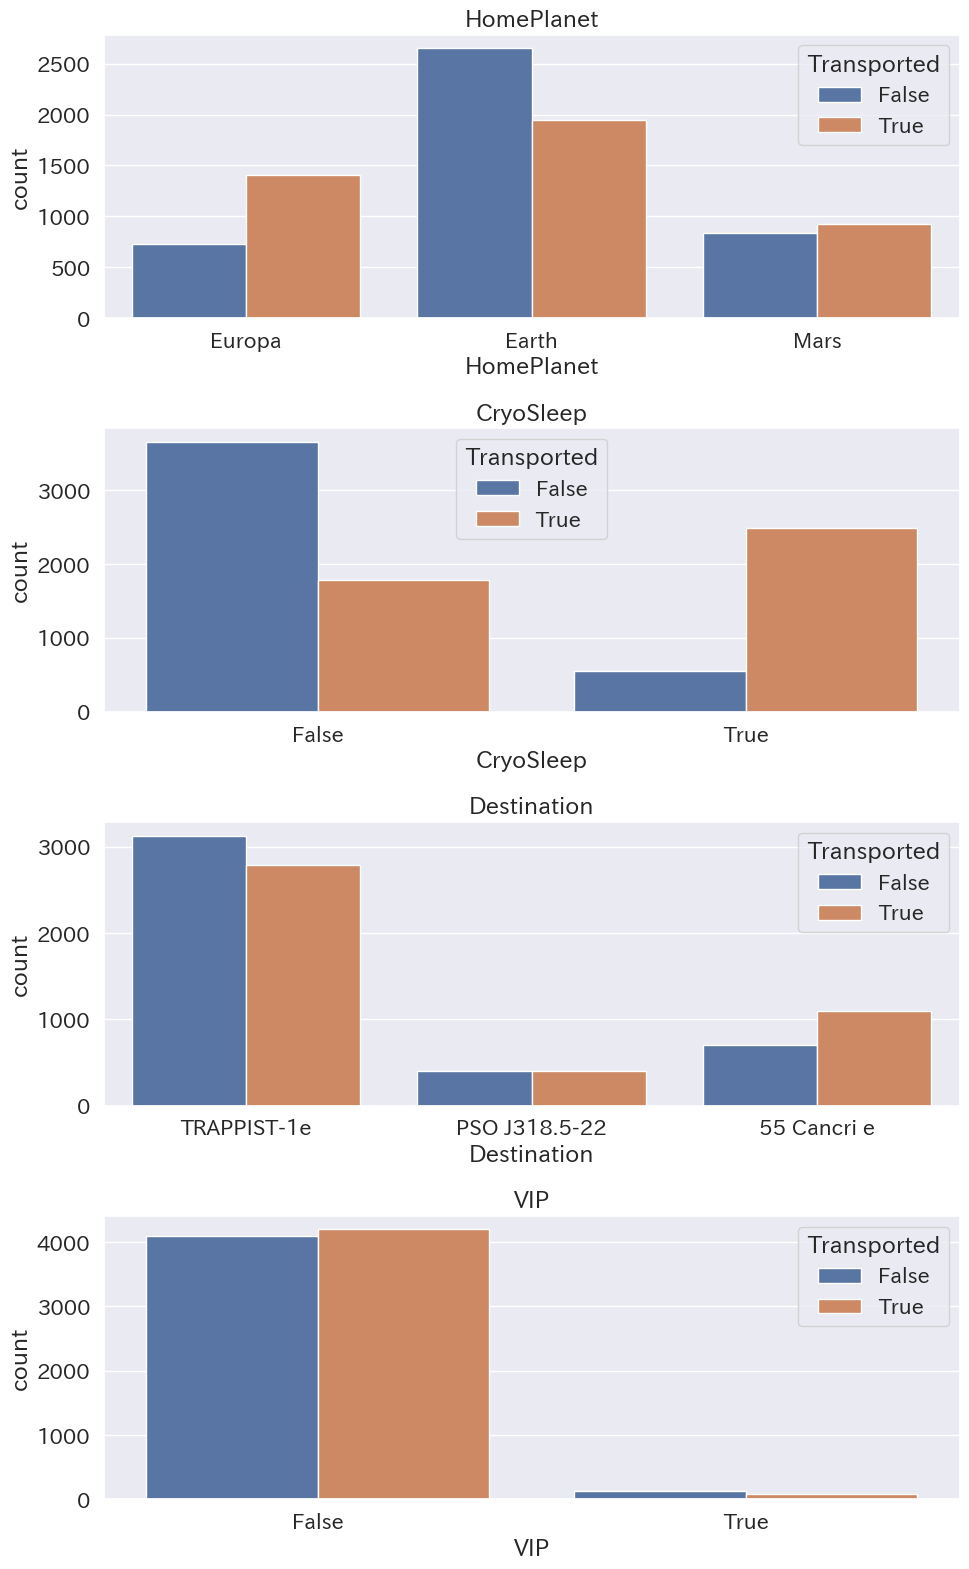

In [ ]:
import enum
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

*VIPは便利な機能ではなさそう\
*CryoSleepは使えそう。凍結を選んだ(True)は輸送される可能性高い。\

*over-fittingを防ぐために、VIP列の削除を検討

In [ ]:
qual_feats = ['PassengerId', 'Cabin', 'Name']
train[qual_feats].head()

PassengerId  Cabin               Name
0     0001_01  B/0/P    Maham Ofracculy
1     0002_01  F/0/S       Juanna Vines
2     0003_01  A/0/S      Altark Susent
3     0003_02  A/0/S       Solam Susent
4     0004_01  F/1/S  Willy Santantines

* PassengerId は gggg_pp の形式で、gggg はご搭乗者が同行するグループ、pp はグループ内の番号。
*キャビンはデッキ/番号/サイドの形式を取り、サイドは左舷の場合はP、右舷の場合はSのいずれか。\
*キャビンの特徴からデッキ、番号、側面を抽出できる。
*家族を識別するために、名前機能から姓を抽出できる


# Feature Engineering

年齢をグループに分ける。年齢に応じた支出などの欠損値を埋めるのに役立つ

Text(0.5, 0.98, 'Age group distribution')

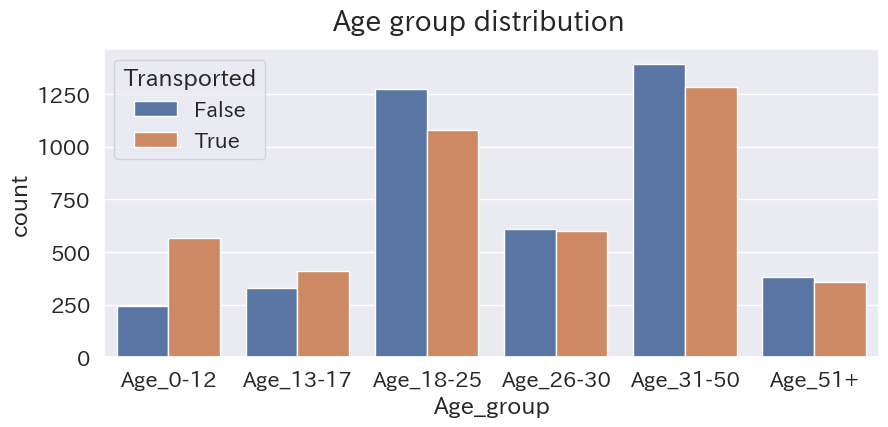

In [ ]:
train['Age_group'] = np.nan #新しい列追加

#置換　'Age'が12より小さい場合、'Age_group'を'Age_0-12'に置き換える
train['Age_group']=np.nan#新しい列追加
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

test['Age_group'] = np.nan #新しい列追加
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.suptitle('Age group distribution')

**支出**\
総支出を計算し、支出のない乗客を特定

In [ ]:
train[exp_feats].head()

RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
0          0.0        0.0           0.0     0.0     0.0
1        109.0        9.0          25.0   549.0    44.0
2         43.0     3576.0           0.0  6715.0    49.0
3          0.0     1283.0         371.0  3329.0   193.0
4        303.0       70.0         151.0   565.0     2.0

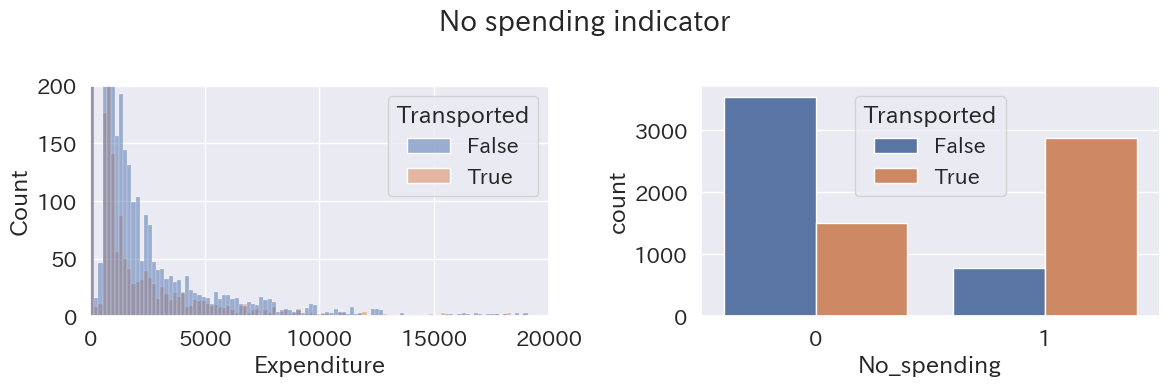

In [ ]:
#横の行をすべて足し合わせて
train['Expenditure'] = train[exp_feats].sum(axis=1) #exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
#施設にお金を払わなかかった人(0の人）
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.suptitle('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.suptitle('No spending indicator')
fig.tight_layout()

No_spending 支払った人０、支払っていない人１

**Passenger group**\
PassengerIDからグループとグループサイズを抽出

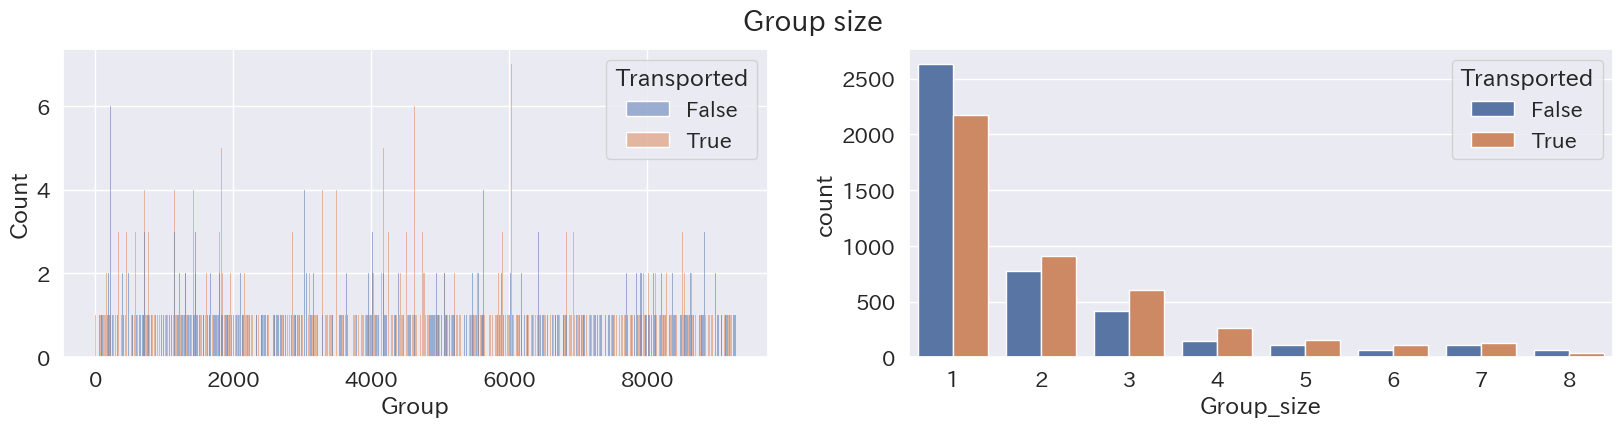

In [ ]:
#'PassengerIDの'_'の部分でsplitしたときのindex0がGroup。0001とか0003とか
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.suptitle('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.suptitle('Group size')
fig.tight_layout()


モデルでグループ機能を実際に使用することができない。one-hot-encodingで次元数が急増するため。\
一方、グループサイズは便利。誰が実際に旅行しているのか見られる「ソロ」列を作成することでさらに圧縮できる。\
*右：group_size=1は1より大きいグループより輸送される可能性が低い

(0.0, 3000.0)

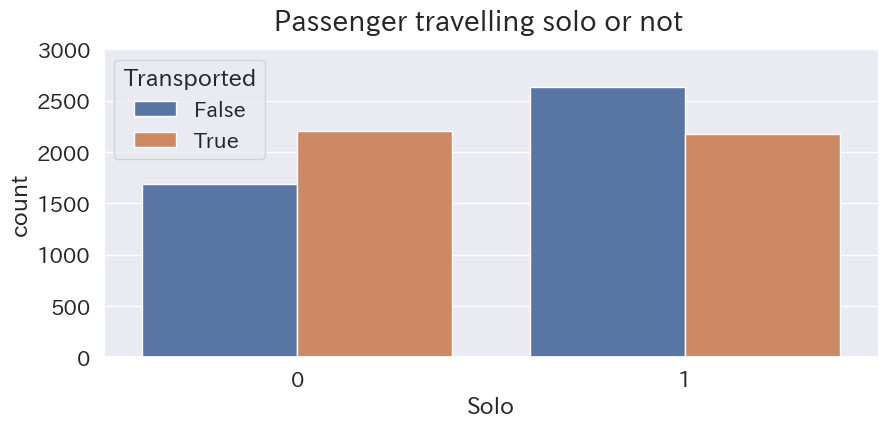

In [ ]:
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.suptitle('Passenger travelling solo or not')
plt.ylim([0,3000])

**Cabin location**\
デッキ、ナンバー、サイドを抽出

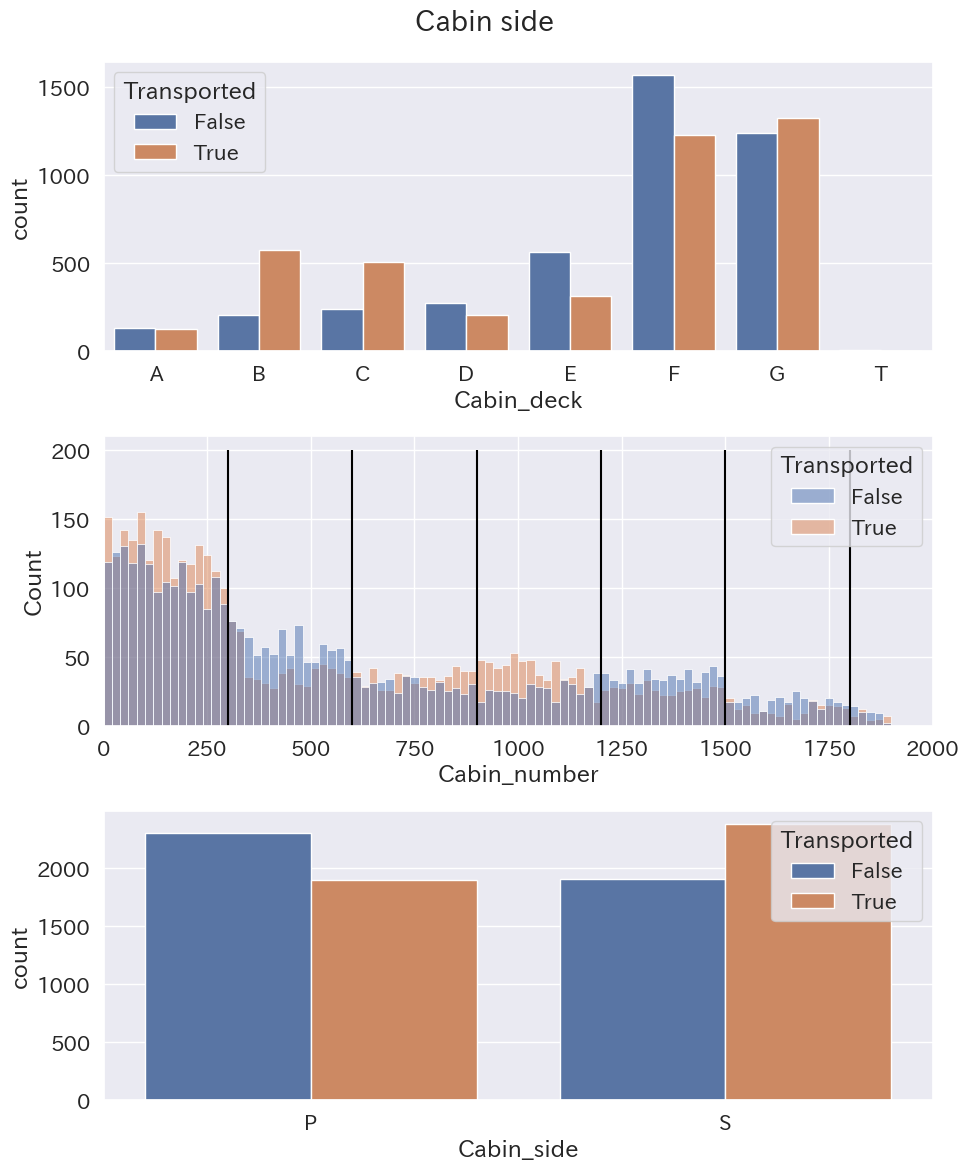

In [ ]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.suptitle('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.suptitle('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.suptitle('Cabin side')
fig.tight_layout()

In [ ]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'rc_log', 'Age_group', 'Expenditure', 'No_spending',
       'Group', 'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number',
       'Cabin_side'],
      dtype='object')

Cabin_numberは300キャビンでグループ化されている。これはカテゴリ別の機能に圧縮できることを意味する。各乗客がどのグループに属しているか示す。\
※Cabin_deckのTは外れ値

In [ ]:
train.loc[train['Cabin_number'] < 300, 'CabinRegion'] = 'region1'
train.loc[(train['Cabin_number']>=300) & (train['Cabin_number'] < 600), 'CabinRegion'] = 'region2'
train.loc[(train['Cabin_number']>=600) & (train['Cabin_number'] < 900), 'CabinRegion'] = 'region3'
train.loc[(train['Cabin_number']>=900) & (train['Cabin_number']<1200), 'CabinRegion'] = 'region4'
train.loc[(train['Cabin_number']>=1200) & (train['Cabin_number']<1500), 'CabinRegion'] = 'region5'
train.loc[(train['Cabin_number']>=1500) & (train['Cabin_number']<1800), 'CabinRegion'] = 'region6'
train.loc[train['Cabin_number']>=1800, 'CabinRegion'] = 'region7'

test.loc[test['Cabin_number'] < 300, 'CabinRegion'] = 'region1'
test.loc[(test['Cabin_number']>=300) & (test['Cabin_number'] < 600), 'CabinRegion'] = 'region2'
test.loc[(test['Cabin_number']>=600) & (test['Cabin_number'] < 900), 'CabinRegion'] = 'region3'
test.loc[(test['Cabin_number']>=900) & (test['Cabin_number']<1200), 'CabinRegion'] = 'region4'
test.loc[(train['Cabin_number']>=1200) & (test['Cabin_number']<1500), 'CabinRegion'] = 'region5'
test.loc[(train['Cabin_number']>=1500) & (test['Cabin_number']<1800), 'CabinRegion'] = 'region6'
test.loc[test['Cabin_number']>=1800, 'CabinRegion'] = 'region7'


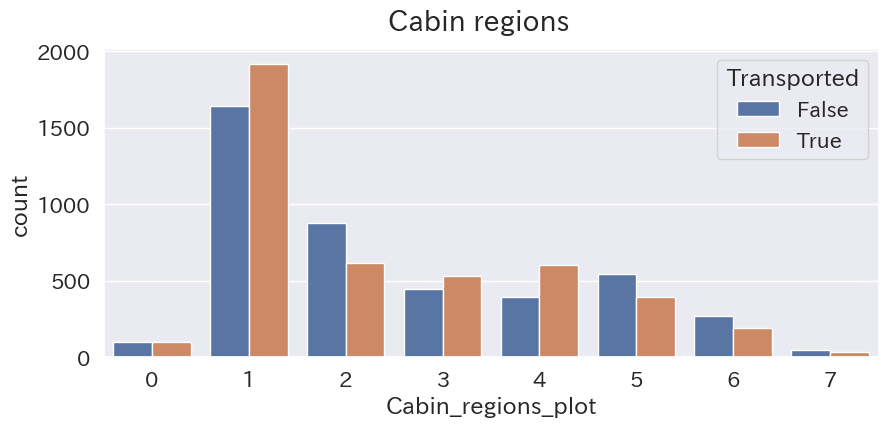

In [ ]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.suptitle('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

**Last name**\
コードを追加マークダウンを追加\
姓から家族のサイズを計算する

Text(0.5, 0.98, 'Family size')

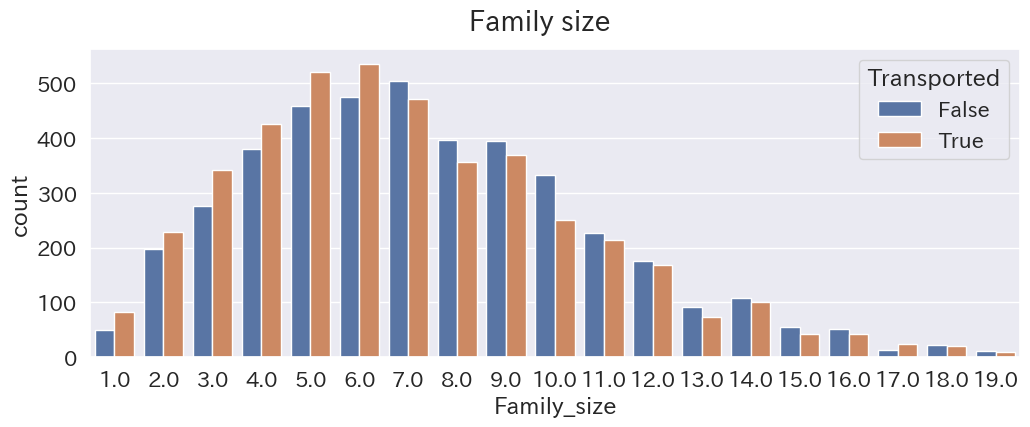

In [ ]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.suptitle('Family size')

#Missing Values

Combine train and test

In [ ]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'rc_log', 'Age_group', 'Expenditure', 'No_spending',
       'Group', 'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number',
       'Cabin_side', 'CabinRegion', 'Cabin_region1', 'Cabin_region2',
       'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6',
       'Cabin_region7', 'Surname', 'Family_size'],
      dtype='object')

In [ ]:
y=train['Transported'].copy().astype(int)#y_trainの部分
X=train.drop('Transported', axis=1).copy()#trainのTransportedをdropした部分つまりX_train

data=pd.concat([X, test], axis=0).reset_index(drop=True)#特徴量をconcat

In [ ]:
na_cols = data.columns[data.isna().any()].tolist()

mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing'] = np.round(100*mv['Number_missing']/len(data), 2)
mv

Number_missing  Percentage_missing
HomePlanet               288                2.22
CryoSleep                310                2.39
Destination              274                2.11
Age                      270                2.08
VIP                      296                2.28
RoomService              263                2.03
FoodCourt                289                2.23
ShoppingMall             306                2.36
Spa                      284                2.19
VRDeck                   268                2.07
rc_log                  4458               34.37
Age_group                270                2.08
Cabin_deck               299                2.31
Cabin_number             299                2.31
Cabin_side               299                2.31
CabinRegion             1021                7.87
Surname                  294                2.27
Family_size              294                2.27

Text(0.5, 0.98, 'Heatmap of missing values')

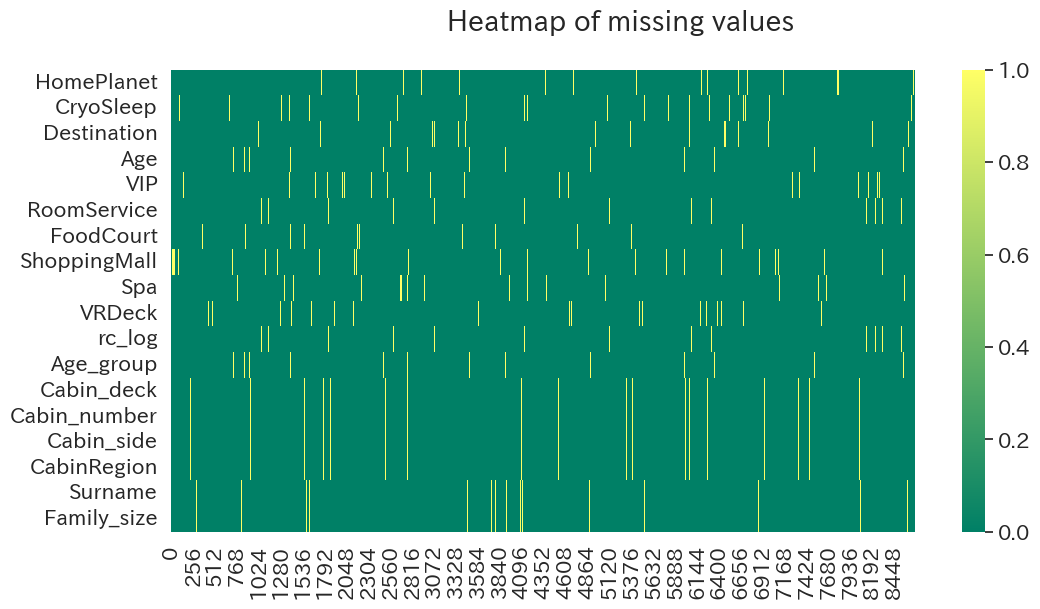

In [ ]:

plt.figure(figsize=(12, 6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.suptitle('Heatmap of missing values')

欠損値はデータの約2％を占めていて、これは比較的少量。ほとんどの場合、それらは同時に発生していないように見える。\
(CabinとNameを分割して作成された機能を除く）

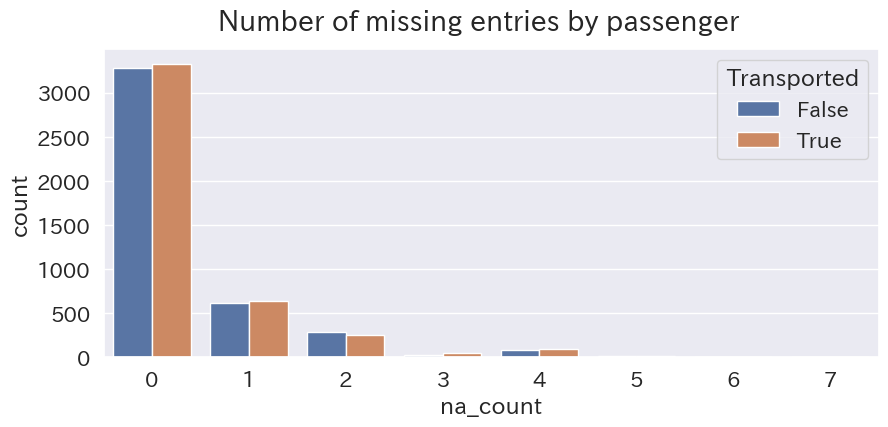

In [ ]:
train['na_count'] = train.isna().sum(axis=1)
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.suptitle('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

欠損値はターゲットから独立しており、ほとんどの場合孤立しています。
* 欠落しているデータはわずか 2% だが、全乗客の約 25% に少なくとも 1 つの欠損値がある。
* PassengerId は、欠損値がない唯一の (元の) 機能
* 欠落している値のほとんどは分離されているため、単に行を削除するのではなく、これらを埋めようとするのは理にかなっている
* PassengerId と他の機能の間に関係がある場合、この列に従って欠損値を埋めることができる

**戦略** 

欠損値を処理する最も簡単な方法は、連続特徴には中央値を使用し、カテゴリ特徴にはモードを使用すること。 これは「十分」に機能するが、モデルの精度を最大化したい場合、欠落しているデータ内のパターンを探す必要がある。 これを行う方法は、機能の共同分布を調べる。 同じグループの乗客は同じ家族から来る傾向がありますか? 当然多くの組み合わせがあるので、私や他の人が発見した有益な傾向を要約する


#HomePlanet
欠損値埋め

**HomePlanet と Group**

In [ ]:
home = data.groupby('HomePlanet')#HomePlanetごと
home.size()

HomePlanet
Earth     6865
Europa    3133
Mars      2684
dtype: int64

In [ ]:
GHP_gb = data.groupby(['Group', 'HomePlanet']).size().unstack().fillna(0)
GHP_gb

HomePlanet  Earth  Europa  Mars
Group                          
1             0.0     1.0   0.0
2             1.0     0.0   0.0
3             0.0     2.0   0.0
4             1.0     0.0   0.0
5             1.0     0.0   0.0
...           ...     ...   ...
9276          0.0     1.0   0.0
9277          1.0     0.0   0.0
9278          1.0     0.0   0.0
9279          1.0     0.0   0.0
9280          0.0     2.0   0.0

[9124 rows x 3 columns]

In [ ]:
'''sns.countplot((GHP_gb>0).sum(axis=1))
plt.title=('Number of unique home planets per group')'''

"sns.countplot((GHP_gb>0).sum(axis=1))\nplt.title=('Number of unique home planets per group')"

これは、同じグループの全員が同じ故郷の惑星から来ていることを示している。\
そのため、グループに従って不足しているHomePlanet値を埋めることができる。(少なくともグループサイズが1より大きいもの）

In [ ]:
aiu = [data[data['HomePlanet'].isna()]['Group'].isin(GHP_gb)]

aiu

[59       False
 113      False
 186      False
 225      False
 234      False
          ...  
 12650    False
 12673    False
 12725    False
 12852    False
 12906    False
 Name: Group, Length: 288, dtype: bool]

In [ ]:
# 欠損値埋め前の欠損値数
HP_bef=data['HomePlanet'].isna().sum()

# HomePlanetが不明だけど、HomePlanetが既存のグループの乗客
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# 対応する欠損値を埋める
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# 残っている欠損値数を出力
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


**HomePlanetとCabinDeck**

HomePlanet   Earth  Europa    Mars
Cabin_deck                        
A              0.0   352.0     0.0
B              0.0  1137.0     0.0
C              0.0  1096.0     0.0
D              0.0   301.0   410.0
E            589.0   199.0   515.0
F           2437.0     0.0  1742.0
G           3731.0     0.0     0.0
T              0.0    10.0     0.0


<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

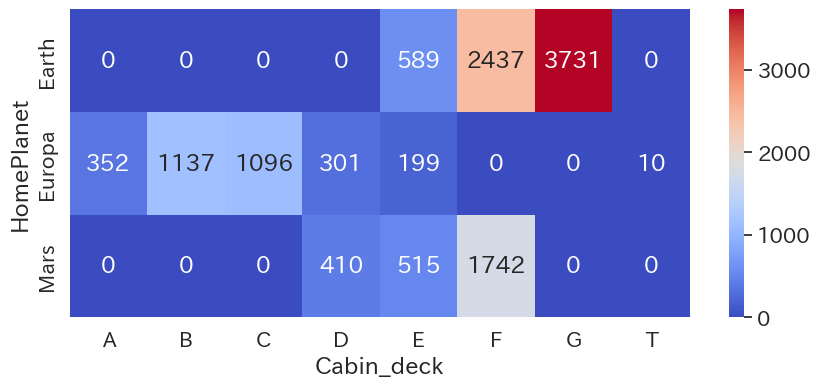

In [ ]:
CDHP_gb = data.groupby(['Cabin_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
print(CDHP_gb)

plt.figure(figsize=(10, 4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

* DeckA,B,C,Tの乗客はエウロパから来た
* Deck Gの乗客は地球から
* Deck D,E,Fの乗客は複数の惑星から

In [ ]:
HP_def = data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet'] = 'Earth'

print('HomePlanet missing values before', HP_def)
print('HomePlanet missing values after', data['HomePlanet'].isna().sum())

HomePlanet missing values before 157
HomePlanet missing values after 94


**HomePlanet と Surname**

HomePlanet   Earth  Europa  Mars
Surname                         
Acobson        5.0     0.0   0.0
Acobsond       8.0     0.0   0.0
Adavisons     10.0     0.0   0.0
Adkinson       4.0     0.0   0.0
Admingried     0.0     4.0   0.0
...            ...     ...   ...
Wynneyerson    2.0     0.0   0.0
Yanton         8.0     0.0   0.0
Yatters        8.0     0.0   0.0
Yorkland      13.0     0.0   0.0
Youngrayes     7.0     0.0   0.0

[2402 rows x 3 columns]


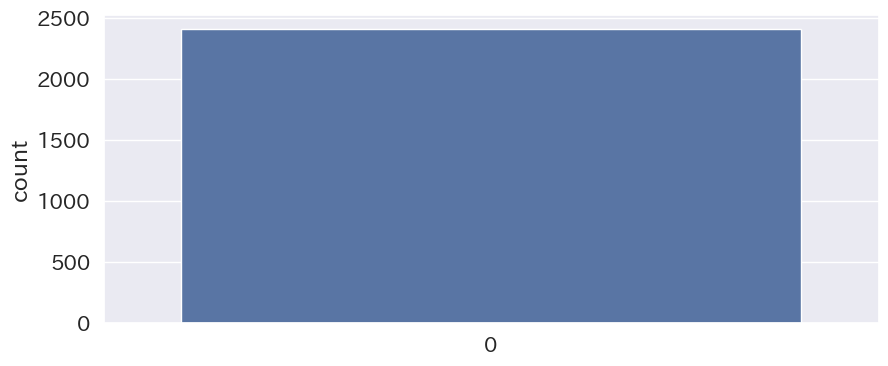

In [ ]:
SHP_gb = data.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
print(SHP_gb)

plt.figure(figsize=(10, 4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title=('Number of unique planets per surname')

同じ苗字の人たちはみんな同じ故郷の星から来ていることがわかる

In [ ]:
HP_bef = data['HomePlanet'].isna().sum()

SHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

data.loc[SHP_index, 'HomePlanet'] = data.iloc[SHP_index, :]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

print('HomePlanet missing values before', HP_bef)
print('HomePlanet missing values after', data['HomePlanet'].isna().sum())

HomePlanet missing values before 94
HomePlanet missing values after 10


あと10個の欠損値を埋める

In [ ]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet', 'Destination','Cabin_deck']]

PassengerId HomePlanet  Destination Cabin_deck
2274      2443_01        NaN  TRAPPIST-1e          D
2631      2817_01        NaN  TRAPPIST-1e          F
3091      3331_01        NaN  TRAPPIST-1e          F
4548      4840_01        NaN  TRAPPIST-1e          F
5762      6108_01        NaN  TRAPPIST-1e          F
8969      0616_01        NaN  TRAPPIST-1e          E
10583     4052_01        NaN  TRAPPIST-1e          D
11913     7065_01        NaN  TRAPPIST-1e          E
12551     8435_01        NaN  TRAPPIST-1e          F
12725     8775_01        NaN  TRAPPIST-1e          D

残りの10人全員TRAPPIST-1eに向かっている。\
HomePlanetとDestinationの共同配布を見てみる

Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet                                          
Earth               1000           1085         4778
Europa              1341             29         1769
Mars                 300             70         2314


<Axes: xlabel='HomePlanet', ylabel='Destination'>

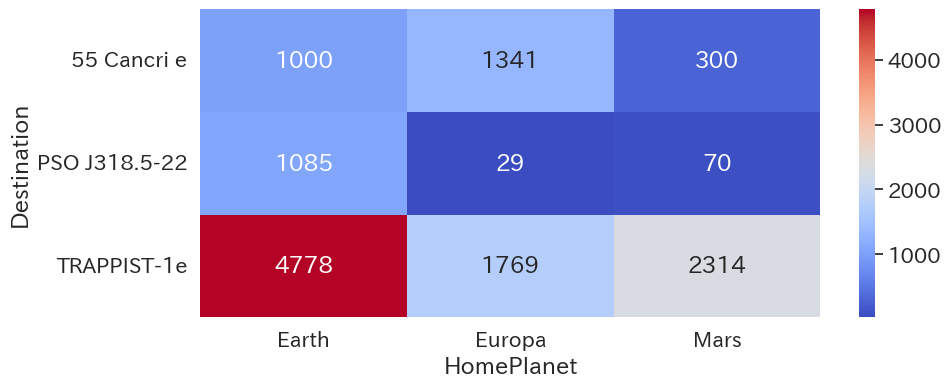

In [ ]:
HPD_gb = data.groupby(['HomePlanet', 'Destination']).size().unstack().fillna(0)
print(HPD_gb)

plt.figure(figsize=(10, 4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

TRAPPIST-1eに向かうほとんどの人は地球から来ている。そこから来たと推測できるが、前でDeck Dには地球から来た人は誰もいなかったため、これらを除外する必要がある。

In [ ]:
HP_bef = data['HomePlanet'].isna().sum()

data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet'] = 'Mars'

print('HomePlanet missing values before ', HP_bef)
print('HomePlanet missing values after', data['HomePlanet'].isna().sum())

HomePlanet missing values before  10
HomePlanet missing values after 0


#Destiantion
欠損値埋め\
乗客の68%がTRAPPIST-1eに向かっているため、すべて適用させることにする

In [ ]:
D_bef=data['Destination'].isna().sum()

data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


#Surname
**Surname　と　group**\
欠落している姓を埋める理由は、後で姓を使用して他の機能の欠落した値を埋めるため。\
また、family_size機能の精度を向上できる

In [ ]:
GSN_gb = data[data['Group_size']>1].groupby(['Group', 'Surname']).size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
#sns.countplot((GSN_gb>0).sum(axis=1))
plt.tilte=('Number of unique surnames by group')

<Figure size 1000x400 with 0 Axes>

グループの大部分には、1つの家族しか含まれていない。グループの多数派の姓に従って、欠落している姓を埋める。

In [ ]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


Surnameはいずれ削除するため、欠損値をすべて取り除く必要はないが、family_size機能は更新できる。

In [ ]:
data['Surname'].fillna('Unknown', inplace=True)

data['Family_size'] = data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

data.loc[data['Surname']=='Unknown', 'Surname'] = np.nan

data.loc[data['Family_size']>100, 'Family_size'] = 0

#Cabin_side
**CabinSide と Group**

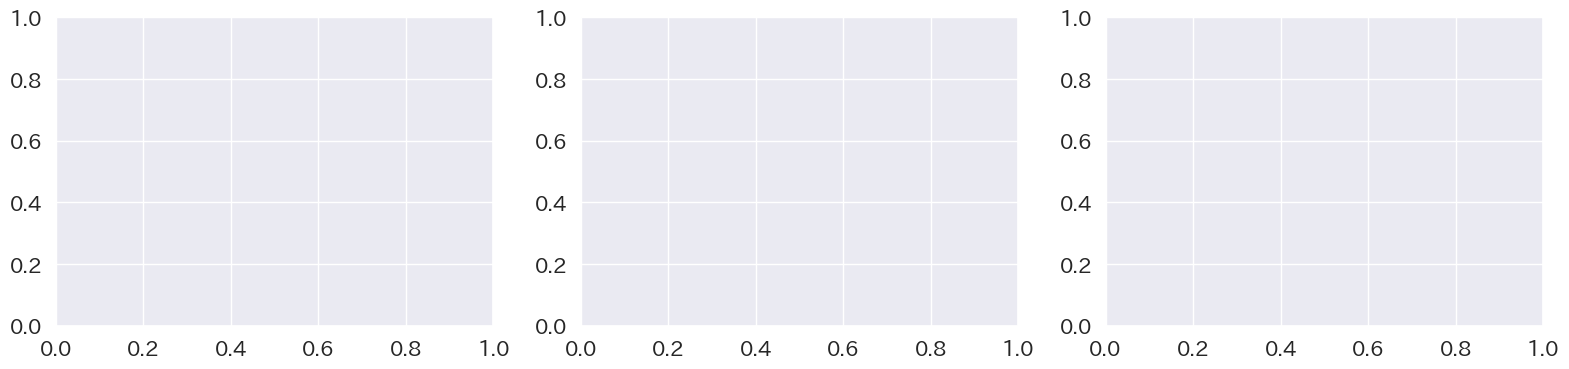

In [ ]:
# GroupとCabin機能の共同
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
#sns.countplot((GCD_gb>0).sum(axis=1))
plt.title=('#Unique cabin decks per group')

plt.subplot(1,3,2)
#sns.countplot((GCN_gb>0).sum(axis=1))
plt.title=('#Unique cabin numbers per group')

plt.subplot(1,3,3)
#sns.countplot((GCS_gb>0).sum(axis=1))
plt.title=('#Unique cabin sides per group')
fig.tight_layout()

もう一つのルールとして、同じグループの全員が同じキャビン側にいる。cabin_deckとcabin_numberについてもグループと相関関係がある可能性が高い

In [ ]:
CS_bef = data['Cabin_side'].isna().sum()

GCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

data.loc[GCS_index, 'Cabin_side'] = data.iloc[GCS_index, :]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

print('Cabin_side missing values before', CS_bef)
print('Cabin_side missing values after', data['Cabin_side'].isna().sum())

Cabin_side missing values before 299
Cabin_side missing values after 162


**CabinSide と Surname**

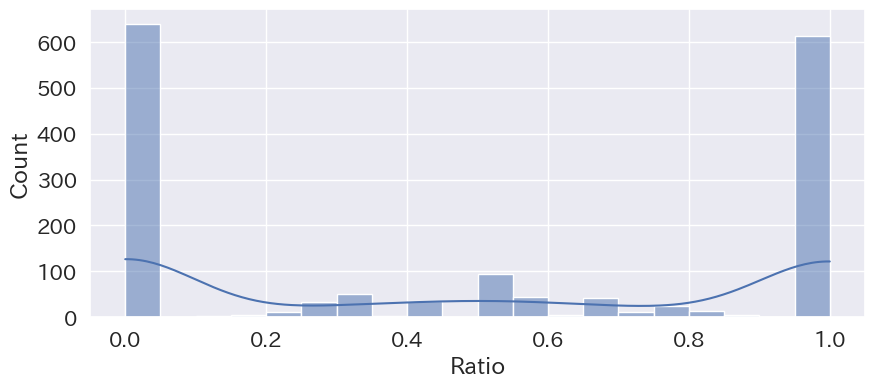

In [ ]:
SCS_gb = data[data['Group_size']>1].groupby(['Surname', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

SCS_gb['Ratio'] = SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

plt.figure(figsize=(10, 4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title=('Ratio of cabin side by surname')

In [ ]:
print('Percentage of families all on the seme cabin side', 100*np.round((SCS_gb['Ratio'].isin([0, 1])).sum()/len(SCS_gb), 3), '%')

SCS_gb.head()

Percentage of families all on the seme cabin side 76.7 %


Cabin_side    P    S  Ratio
Surname                    
Acobson     0.0  3.0    0.0
Acobsond    3.0  0.0    1.0
Adavisons   6.0  0.0    1.0
Admingried  0.0  4.0    0.0
Aginge      3.0  0.0    1.0

In [ ]:
CS_bef = data['Cabin_side'].isna().sum()

SCS_gb.drop('Ratio', axis=1, inplace=True)
SCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

data.loc[SCS_index, 'Cabin_side'] = data.iloc[SCS_index, :]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

data.drop('Surname', axis=1, inplace=True)

print('Cabin_side missing values before', CS_bef)
print('Cabin_side missing values after', data['Cabin_side'].isna().sum())

Cabin_side missing values before 162
Cabin_side missing values after 66


In [ ]:
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

In [ ]:
CS_bef = data['Cabin_side'].isna().sum()
data.loc[data['Cabin_side'].isna(), 'Cabin_side'] = 'Z'

print('Cabin_side missing values before', CS_bef)
print('Cabin_side missing values after', data['Cabin_side'].isna().sum())

Cabin_side missing values before 66
Cabin_side missing values after 0


#Cabin_deck
**CabinDeck と Group**\
グループは同じCabin_Deckにいる傾向がある

In [ ]:
CD_bef = data['Cabin_deck'].isna().sum()

GCD_index = data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index
data.loc[GCD_index, 'Cabin_deck'] = data.iloc[GCD_index, :]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])
print('Cabin_deck missing values before', CD_bef)
print('Cabin_deck missing values after', data['Cabin_deck'].isna().sum())

Cabin_deck missing values before 299
Cabin_deck missing values after 162


**CabinDeck と HomePlanet**

In [ ]:
data.groupby(['HomePlanet', 'Destination', 'Solo', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)


Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

* Masからの乗客はDeck F にいる可能性が最も高い
* Europaからの乗客は (多かれ少なかれ) 単独で旅行する場合はDeck C に、それ以外の場合はDeck B にいる可能性が最も高い。
* Earthからの乗客は (多かれ少なかれ)Deck 
G にいる可能性が最も高い.\

moodがこれらのサブグループのどこに現れるかに応じて、欠損値を埋める

In [ ]:
CD_bef = data['Cabin_deck'].isna().sum()

na_rows_CD = data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'] = data.groupby(['HomePlanet', 'Destination', 'Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

print('Cabin_deck missing values before', CD_bef)
print('Cabin_deck missing values after', data['Cabin_deck'].isna().sum())

Cabin_deck missing values before 162
Cabin_deck missing values after 0


#Cabin_number
**CabinNumber と CabinDeck**

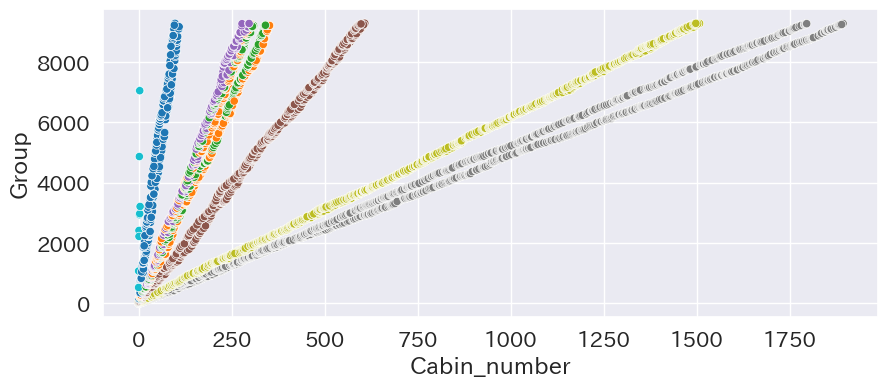

In [ ]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(), 'Cabin_deck']), cmap='tab10')
plt.title=('Cabin_number とグループ別に色分けされたグループ')

あるパターンが存在する。\
Cabin_numberとGroup_numberはDeckごとに線形関係がある。\
よって、Deckごとに線形回帰を使用して不足しているCabin_numberを推定し、\
おおよそのCabin_numberを取得できる。

In [ ]:
CN_bef = data['Cabin_number'].isna().sum()

for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
  X_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Group']
  y_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Cabin_number']
  X_test_CN = data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Group']

  model_CN = LinearRegression()
  model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
  preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))

  data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Cabin_number'] = preds_CN.astype(int)

print('Cabin_number missing values before', CN_bef)
print('Cabin_number missing values after', data['Cabin_number'].isna().sum())

Cabin_number missing values before 299
Cabin_number missing values after 0


**Cabin領域を新しいデータで更新**

In [ ]:
data['Cabin_region1'] = (data['Cabin_number']<300).astype(int)
data['Cabin_region2'] = ((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3'] = ((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4'] = ((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5'] = ((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6'] = ((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7'] = (data['Cabin_number']>=1800).astype(int)

In [ ]:
data.loc[data['Cabin_number'] < 300, 'CabinRegion'] = 'region1'
data.loc[(data['Cabin_number']>=300) & (data['Cabin_number'] < 600), 'CabinRegion'] = 'region2'
data.loc[(data['Cabin_number']>=600) & (data['Cabin_number'] < 900), 'CabinRegion'] = 'region3'
data.loc[(data['Cabin_number']>=900) & (data['Cabin_number'] < 1200), 'CabinRegion'] = 'region4'
data.loc[(data['Cabin_number']>=1200) & (data['Cabin_number'] < 1500), 'CabinRegion'] = 'region5'
data.loc[(data['Cabin_number']>=1500) & (data['Cabin_number']<1800), 'CabinRegion'] = 'region6'
data.loc[data['Cabin_number']>=1800, 'CabinRegion'] = 'region7'


#VIP
VIPは非常にバランスの取れていないバイナリ機能であるため、モードを補完するだけ

In [ ]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [ ]:
V_bef = data['VIP'].isna().sum()
data.loc[data['VIP'].isna(), 'VIP'] = False

print('VIP missing values before', V_bef)
print('VIP missing values after', data['VIP'].isna().sum())

VIP missing values before 296
VIP missing values after 0


#Age
AgeはHomePlanet, Group_size, expenditure, cabin_deckなどの多くの機能によって異なるため、これらのサブグループの中央値に従って欠損値を代入。

In [ ]:
data.groupby(['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck'])['Age'].median().unstack().fillna(0)


Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [ ]:
A_bef = data[exp_feats].isna().sum().sum()

na_rows_A = data.loc[data['Age'].isna(), 'Age'].index
data.loc[data['Age'].isna(), 'Age'] = data.groupby(['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

print('Age missing values before', A_bef)
print('Age missing values after', data['Age'].isna().sum())

Age missing values before 1410
Age missing values after 0


Age_groupのデータを再更新する

In [ ]:
data.loc[data['Age']<=12, 'Age_group'] = 'Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18), 'Age_group'] = 'Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25), 'Age_group'] = 'Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30), 'Age_group'] = 'Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50), 'Age_group'] = 'Age_31-50'
data.loc[data['Age']>50, 'Age_group'] = 'Age_51+'

#CryoSleep
乗客がCryoSleepを使用しているかどうかを予測する最善の方法は、乗客が何かを費やしたかどうかを確認すること。

In [ ]:
data.groupby(['No_spending', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)


CryoSleep     False    True
No_spending                
0            7339.0     0.0
1             740.0  4581.0

In [ ]:
CSL_bef = data['CryoSleep'].isna().sum()

na_rows_CSL = data.loc[data['CryoSleep'].isna(), 'CryoSleep'].index
data.loc[data['CryoSleep'].isna(), 'CryoSleep'] = data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

print('CryoSleep missing values before', CSL_bef)
print('CryoSleep missing values after', data['CryoSleep'].isna().sum())

CryoSleep missing values before 310
CryoSleep missing values after 0


#**Expenditure**
**Expenditure　と CryoSleep**\
CryoSleepの利用者が何かを消費できるとは考えられない。

In [ ]:
print('CryoSleepでの乗客の最大支出', data.loc[data['CryoSleep']==True, exp_feats].sum(axis=1).max() )

CryoSleepでの乗客の最大支出 0.0


In [ ]:
E_bef = data[exp_feats].isna().sum().sum()

for col in exp_feats:
  data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

print('Expenditure missing values before', E_bef)
print('Expenditure missing values after', data[exp_feats].isna().sum().sum())

Expenditure missing values before 1410
Expenditure missing values after 866


#Expenditure and other

支出は多くの機能で異なるが、over-fittingを防ぐために、HomePlanet, Solo, Ageグループを使用して欠損値のみを代入する。\
また、乗客の大部分は何も消費せず、中央値は通用０になるため、中央値の代わりに平均値を使用。\
12歳未満は何も消費しないことに注意する

In [ ]:
data.groupby(['HomePlanet', 'Solo', 'Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [ ]:
E_bef = data[exp_feats].isna().sum().sum()

for col in exp_feats:
  na_rows = data.loc[data[col].isna(), col].index
  data.loc[data[col].isna(), col] = data.groupby(['HomePlanet', 'Solo', 'Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

print('Expenditure missing values before', E_bef)
print('Expenditre missing values after', data[exp_feats].isna().sum().sum())

Expenditure missing values before 866
Expenditre missing values after 0


これらの新しいデータを使用して、支出とNo_spending 機能を更新できる

In [ ]:
data['Expenditure'] = data[exp_feats].sum(axis=1)
data['No_spending'] = (data['Expenditure']==0).astype(int)

In [ ]:
data.isna().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
rc_log           4458
Age_group           0
Expenditure         0
No_spending         0
Group               0
Group_size          0
Solo                0
Cabin_deck          0
Cabin_number        0
Cabin_side          0
CabinRegion         0
Cabin_region1       0
Cabin_region2       0
Cabin_region3       0
Cabin_region4       0
Cabin_region5       0
Cabin_region6       0
Cabin_region7       0
Family_size         0
dtype: int64

#**Preprocessing**
dataをtrainとtestに分割しなおす\
train: X_train訓練データ, y_train訓練target（Transported）\
test: X_testテストデータ, y_testテストtarget(Transported)\
Xは特徴量、ｙはTransported

In [ ]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'rc_log',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'CabinRegion',
       'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4',
       'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [ ]:
X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

いらない特徴量の削除

In [ ]:
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X.drop(['VIP'], axis=1, inplace=True)
X_test.drop(['VIP'], axis=1, inplace=True)
X.drop((X.filter(regex=('^Cabin_region'), axis=1)), axis=1, inplace=True)

'''X.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)
X_test.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)'''

X['CryoSleep'] = X['CryoSleep'].astype(int)
X_test['CryoSleep'] = X_test['CryoSleep'].astype(int)

In [ ]:
tester = pd.concat([X, train['Transported']], axis=1)
tester_test = X_test

tester['Transported'] = tester['Transported'].astype(int)

In [ ]:
#ダミー変数
'''X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)'''

#target encoding
HomePlanet_means = tester.groupby('HomePlanet')['Transported'].mean()
Destination_means = tester.groupby('Destination')['Transported'].mean()
Cabin_deck_means = tester.groupby('Cabin_deck')['Transported'].mean()
Cabin_side_means = tester.groupby('Cabin_side')['Transported'].mean()
#CabinRegion_means = tester.groupby('CabinRegion')['Transported'].mean()

tester['HomePlanet_target'] = tester['HomePlanet'].map(HomePlanet_means)
tester['Destination_target'] = tester['Destination'].map(Destination_means)
tester['Cabin_deck_means'] = tester['Cabin_deck'].map(Cabin_deck_means)
tester['Cabin_side_means'] = tester['Cabin_side'].map(Cabin_side_means)
#tester['CabinRegion_means'] = tester['CabinRegion'].map(CabinRegion_means)

In [ ]:
tester.drop(tester.select_dtypes(include='object'), axis=1, inplace=True)

In [ ]:
#ダミー変数
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

In [ ]:
#オートスケーリング
X = (X - X.mean()) / X.std()
X_test = (X_test - X_test.mean()) / X_test.std()

tester = (tester - tester.mean()) / tester.std()

In [ ]:
'''X_train_numerical = X_train.select_dtypes(include=['int64', 'float64'])
X_train_numerical = (X_train_numerical - X_train_numerical.mean()) / X_train_numerical.std()#標準化
X_train_object = pd.get_dummies(X_train.select_dtypes(include='object'))#数値変換
X_train_std = pd.concat([X_train_object, X_train_numerical], axis='columns')#X_trainの標準化したものと数値変換したものを合体

X_test_numerical = X_test.select_dtypes(include=['int64', 'float64'])
X_test_numerical = (X_test_numerical - X_test_numerical.mean()) / X_test_numerical.std()#標準化
X_test_object = pd.get_dummies(X_test.select_dtypes(include='object'))#数値変換
X_test_std = pd.concat([X_test_object, X_test_numerical], axis='columns')#X_trainの標準化したものと数値変換したものを合体
'''




"X_train_numerical = X_train.select_dtypes(include=['int64', 'float64'])\nX_train_numerical = (X_train_numerical - X_train_numerical.mean()) / X_train_numerical.std()#標準化\nX_train_object = pd.get_dummies(X_train.select_dtypes(include='object'))#数値変換\nX_train_std = pd.concat([X_train_object, X_train_numerical], axis='columns')#X_trainの標準化したものと数値変換したものを合体\n\nX_test_numerical = X_test.select_dtypes(include=['int64', 'float64'])\nX_test_numerical = (X_test_numerical - X_test_numerical.mean()) / X_test_numerical.std()#標準化\nX_test_object = pd.get_dummies(X_test.select_dtypes(include='object'))#数値変換\nX_test_std = pd.concat([X_test_object, X_test_numerical], axis='columns')#X_trainの標準化したものと数値変換したものを合体\n"

In [ ]:
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']):
  plt.subplot(6, 2, 2*i+1)
  sns.histplot(X[col], binwidth=100)
  plt.ylim([0, 200])
  plt.suptitle(f'{col} (original)')


  plt.subplot(6, 2, 2*i+2)
  sns.histplot(np.log(1+X[col]), color='C1')
  plt.ylim([0, 200])
  plt.suptitle(f'{col} (log-transform)')

fig.tight_layout()
#plt.show()

Error in callback <function flush_figures at 0x7f1d1bcba940> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']:
  X[col] = np.log(1+X[col])
  X_test[col] = np.log(1+X_test[col])

KeyboardInterrupt: ignored

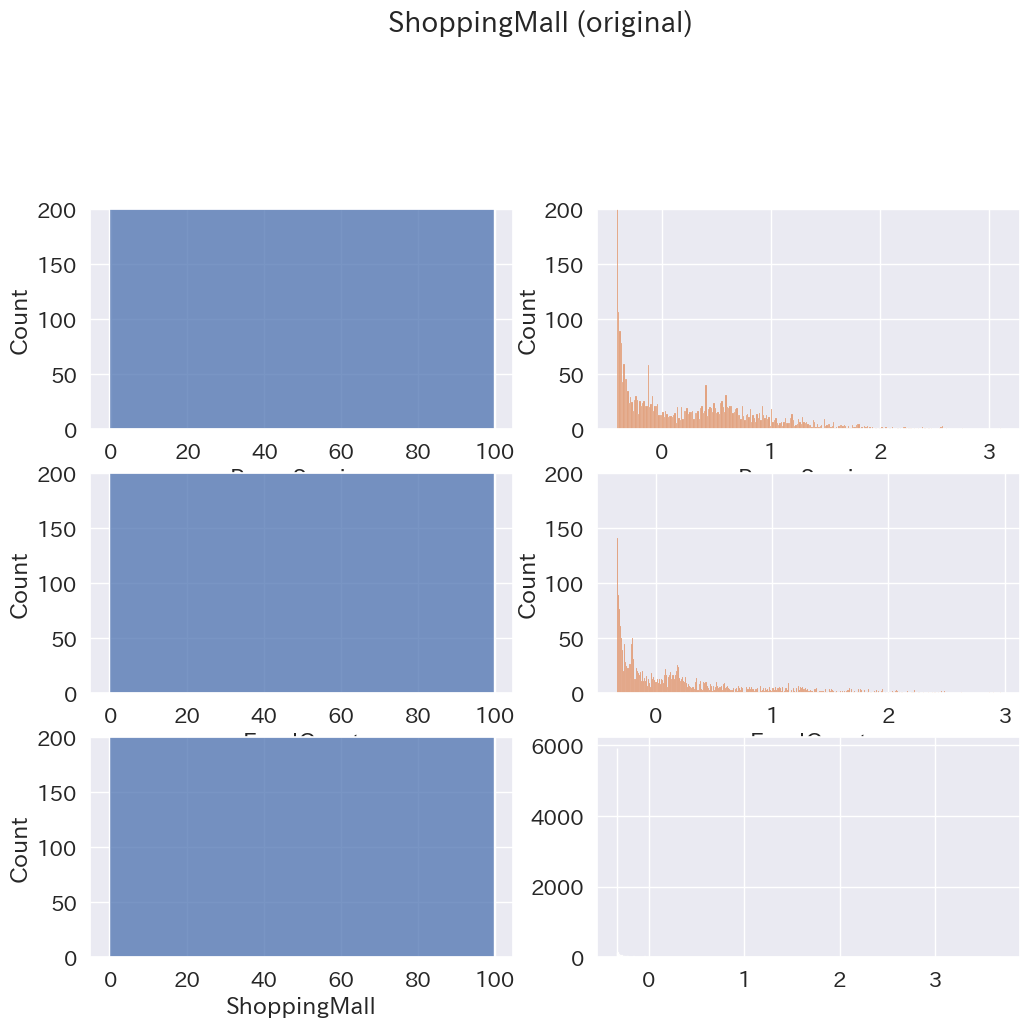

In [ ]:
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']):
  plt.subplot(6, 2, 2*i+1)
  sns.histplot(tester[col], binwidth=100)
  plt.ylim([0, 200])
  plt.suptitle(f'{col} (original)')


  plt.subplot(6, 2, 2*i+2)
  sns.histplot(np.log(1+tester[col]), color='C1')
  plt.ylim([0, 200])
  plt.suptitle(f'{col} (log-transform)')

fig.tight_layout()
#plt.show()
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']:
  tester[col] = np.log(1+tester[col])
  #X_test[col] = np.log(1+X_test[col])

In [ ]:
sns.pairplot(tester)

In [ ]:
from scipy.stats import pearsonr

peason = tester.corr(method='pearson')
pr_corr_df = pd.DataFrame()
pr_corr_df = peason.round(decimals=3).astype(str)
pr_corr_df
pr_corr_df.sort_values('Transported')

**Encoding と scaling**\
より専門的になるために、column transformersを使用する。\
標準化とone-hot encoderをする¥
X_trainとX_testを標準化、数値変換

標準化、エンコーディングしているが、配列に変換されていて、列名が出ない


In [ ]:
'''numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
#categorical_cols = [cname for cname in X.columns if X[cname].dtype == 'object']

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])#int型、float型は標準化

#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False))])#object型はone-hotエンコーディング
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols), 
        #('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

X = ct.fit_transform(X)
X_test = ct.transform(X_test)

print('Training set shape', X.shape)'''

**PCA**
主成分分析\
PCA空間を見てみる。これによりデータの低次元表現が得られる。ローカル構造とグローバル構造が保持される。

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)#特徴量Xたちを主成分分析

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter(
    components, x=0, y=1,color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title = f' Total Explained Variance分散説明率: {total_var: .2f}%',
    labels = {'0': 'PC 1', '1': 'PC 2'},
    width=800, height= 500
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)#特徴量Xたちを主成分分析

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1,z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title = f' Total Explained Variance分散説明率: {total_var: .2f}%',
    labels = {'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height= 500
)
fig.show()

In [ ]:
components_df = pd.DataFrame(components)
components_df

In [ ]:
from sklearn.decomposition import KernelPCA
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10, 4))
xi = np.arange(1, 1+X.shape[1], step=1)#x値: a.shape[0]はaの行(row)の数、a.shape[1]は列(col)の数、a.shape[2]はチャンネル数
yi = np.cumsum(pca.explained_variance_ratio_)#y値：pcaの各成分による寄与率
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0, 1.1)
plt.xlabel('成分の数')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))

plt.ylabel('累積寄与率(%)')
plt.suptitle('各成分による寄与率')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color='red')
ax.grid(axis='x')

In [ ]:
pca_ratio = pca.explained_variance_ratio_
pca_df = pd.DataFrame(data=pca_ratio, columns=['寄与率'])
pca_df

In [ ]:
pca = PCA()
pca.fit(X)

features = pca.transform(X)

plt.scatter(features[:, 0], features[:, 1])
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.savefig("PCA_sample1")
plt.show()

対数変換は、特に外れ値が大きい場合に分布の歪みを減らすために使用される。\
アルゴリズムが正しい関係を学習しやすくなる。\
これらは外れ値によって大きく歪められているため、expenditure機能に適用する

# Proprocessing leave one out


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.9 MB/s eta 0:00:00


In [ ]:
y=train['Transported'].copy().astype(int)
y = pd.DataFrame(y)
X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number', 'VIP'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number', 'VIP'], axis=1, inplace=True)

X.drop((X.filter(regex=('^Cabin_region'), axis=1)), axis=1, inplace=True)
X_test.drop((X_test.filter(regex=('^Cabin_region'), axis=1)), axis=1, inplace=True)
'''X.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)
X_test.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)'''

X['CryoSleep'] = X['CryoSleep'].astype(int)
X_test['CryoSleep'] = X_test['CryoSleep'].astype(int)

In [ ]:
X.drop('rc_log', axis=1, inplace=True)

In [ ]:
X_test.drop('rc_log', axis=1, inplace=True)

In [ ]:
X = pd.concat([X, y], axis=1)

X['Transported'] = X['Transported'].astype(int)

In [ ]:
#Cabin_deck CabinRegion　leave one out encoding
import category_encoders as ce

feat = ['CabinRegion', 'Cabin_deck']
for i, col in enumerate(feat):
  te = ce.LeaveOneOutEncoder(cols=feat[i])
  X[feat[i]] = te.fit_transform(X[feat[i]], X['Transported'])
  X_test[feat[i]] = te.transform(X_test[feat[i]])

In [ ]:
#オートスケーリング
X = (X - X.mean()) / X.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [ ]:
#対数変換
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']:
  X[col] = np.log(1+X[col])
  X_test[col] = np.log(1+X_test[col])

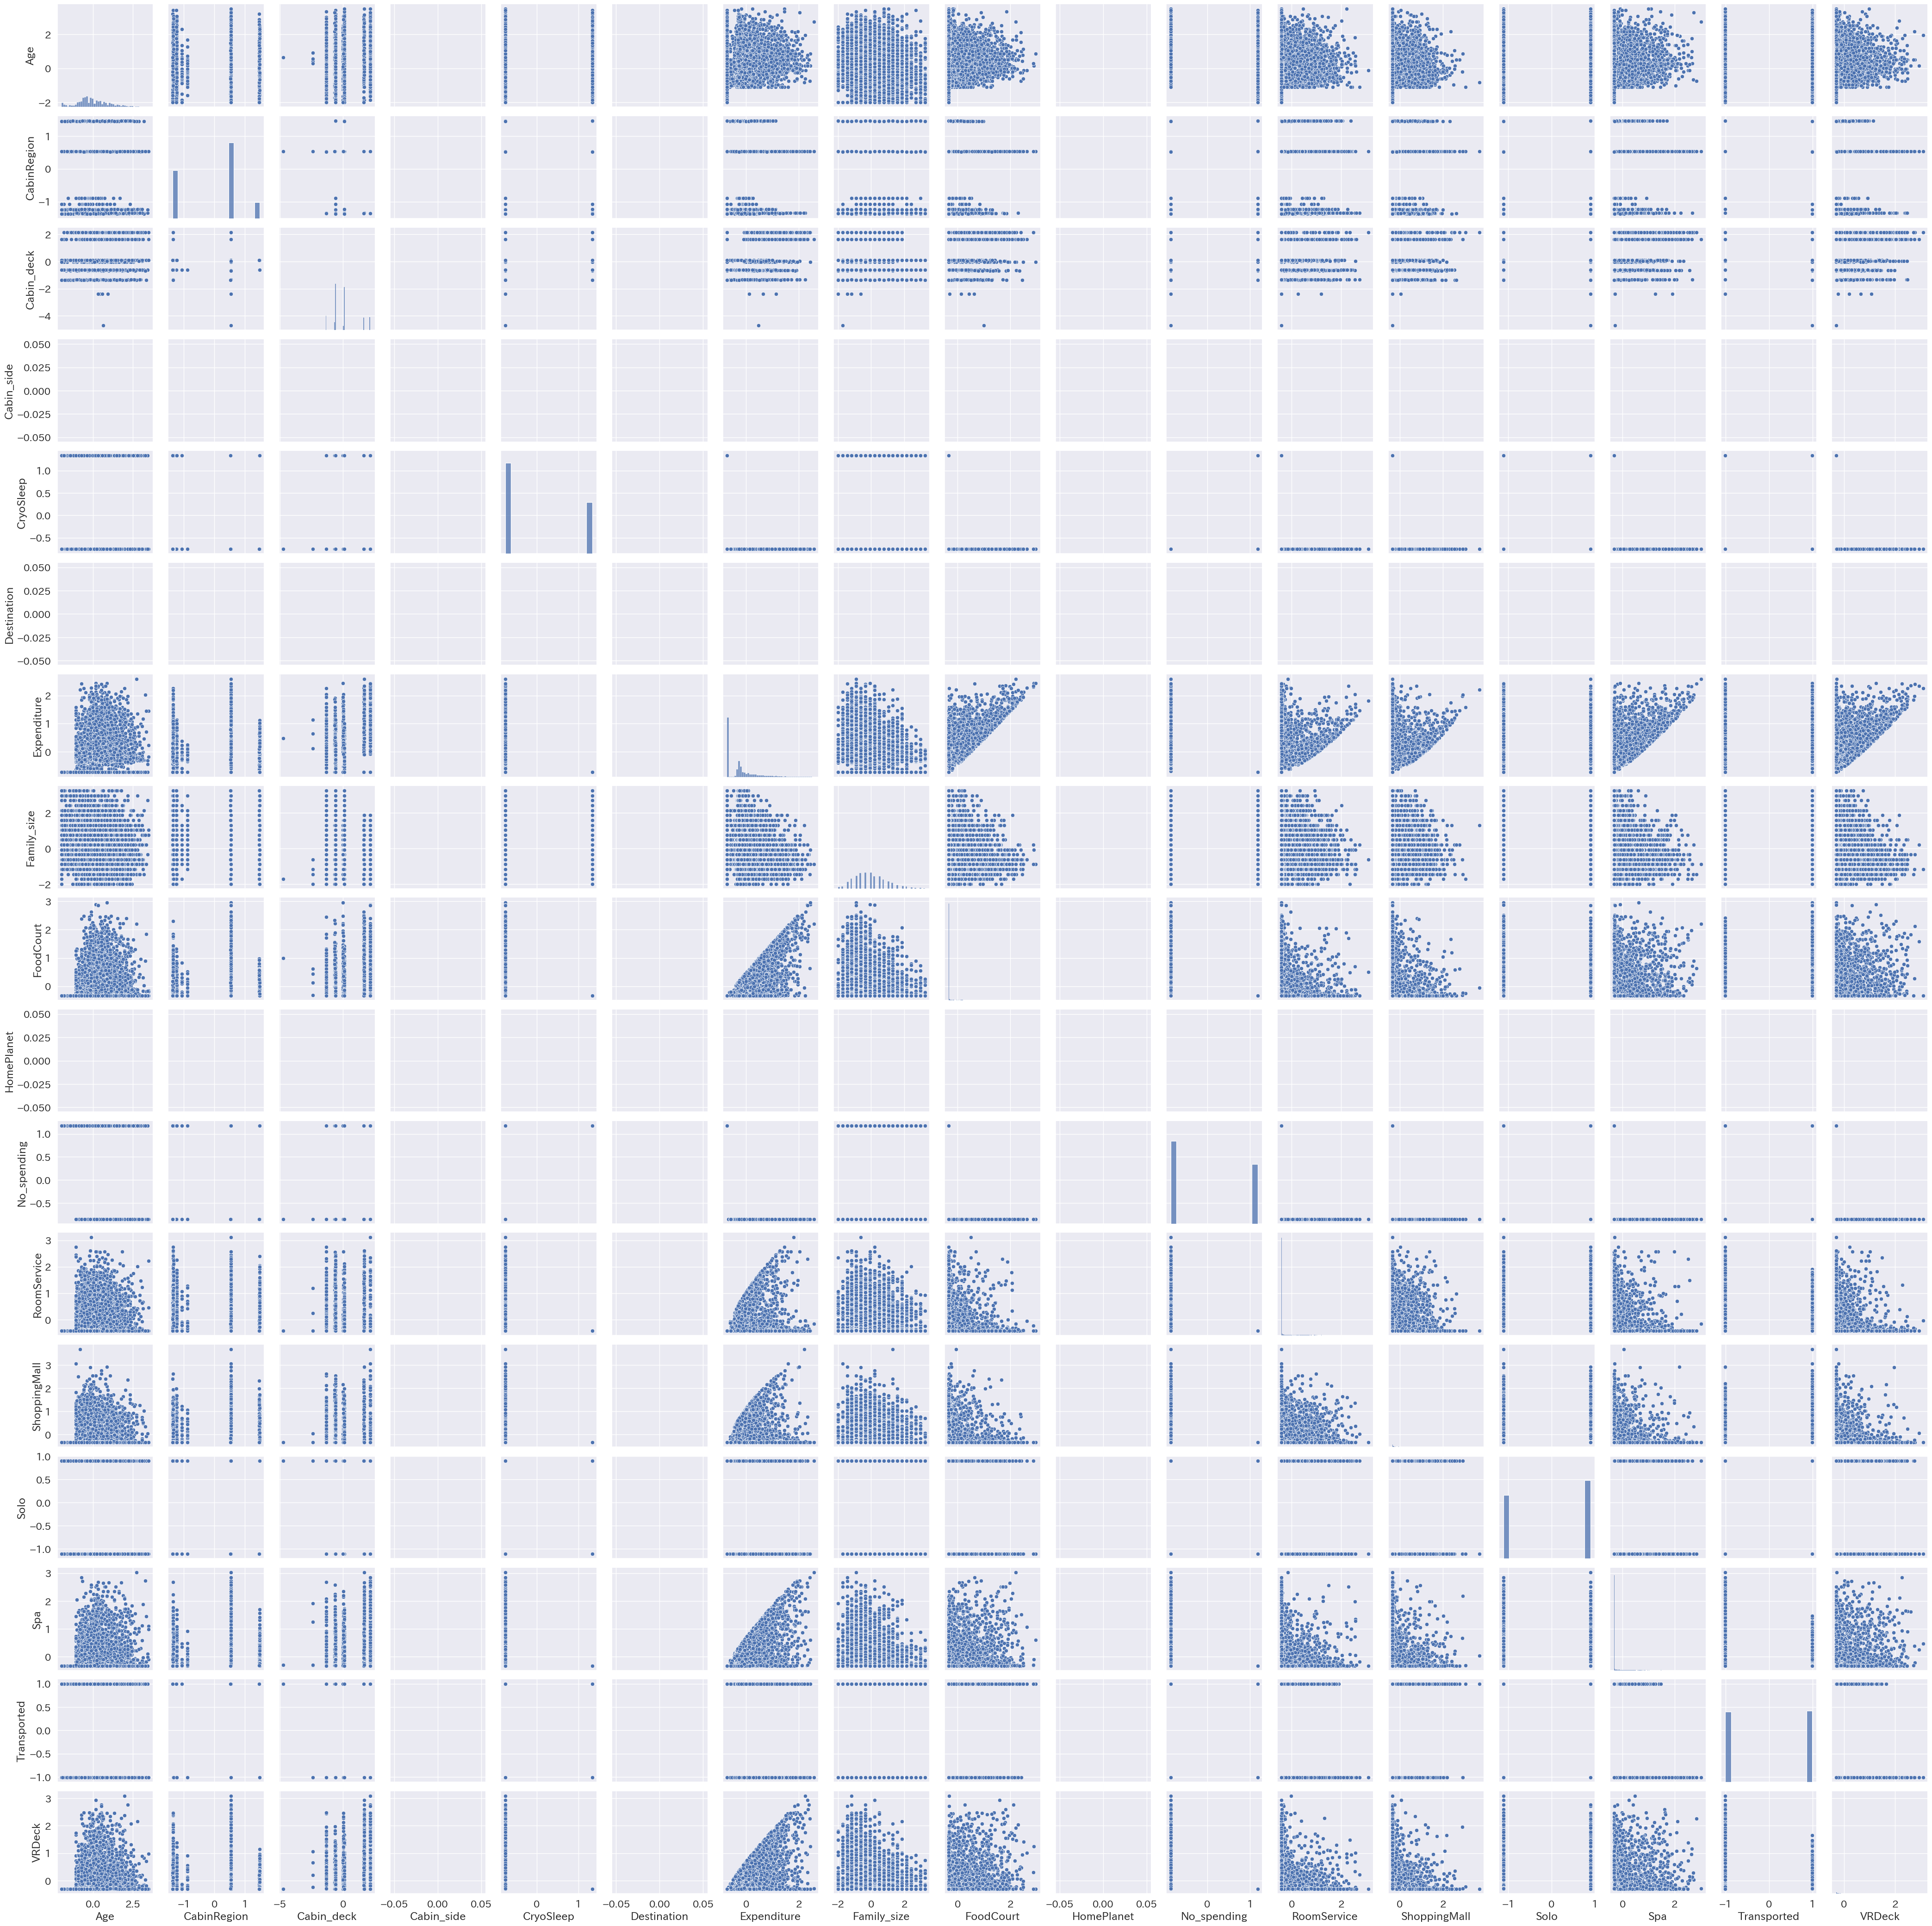

In [ ]:
sns.pairplot(X)
plt.savefig('pariplot.png')

In [ ]:
from scipy.stats import pearsonr

peason = X.corr(method='pearson')
pr_corr_df = pd.DataFrame()
pr_corr_df = peason.round(decimals=3).astype(str)
pr_corr_df.sort_values(['Transported'], ascending=0)

Age CabinRegion Cabin_deck CryoSleep Expenditure Family_size  \
Transported   -0.075        0.13      0.209     0.467      -0.332      -0.051   
No_spending   -0.233        0.05      0.222     0.884      -0.717       0.019   
CryoSleep     -0.082        0.05      0.222       1.0      -0.634      -0.017   
Cabin_deck     0.102       0.205        1.0     0.222       0.143      -0.147   
CabinRegion    0.028         1.0      0.205      0.05       0.065      -0.056   
FoodCourt      0.174       0.089      0.283    -0.315         0.7      -0.137   
Expenditure    0.248       0.065      0.143    -0.634         1.0      -0.153   
RoomService    0.095      -0.027     -0.209    -0.357       0.338      -0.023   
Spa            0.155       0.051      0.156    -0.317       0.593        -0.1   
VRDeck         0.136       0.053      0.197    -0.309        0.59      -0.103   
Solo           0.137      -0.071     -0.216    -0.099      -0.006      -0.139   
Age              1.0       0.028      0.102    -0.082       0.248      -0.135   
Family_size   -0.135      -0.056     -0.147    -0.017      -0.153         1.0   
ShoppingMall   0.064      -0.026     -0.158    -0.337       0.304      -0.017   

             FoodCourt No_spending RoomService ShoppingMall    Solo     Spa  \
Transported       0.01       0.483      -0.316        -0.05  -0.114    -0.3   
No_spending     -0.357         1.0      -0.404       -0.381  -0.187  -0.358   
CryoSleep       -0.315       0.884      -0.357       -0.337  -0.099  -0.317   
Cabin_deck       0.283       0.222      -0.209       -0.158  -0.216   0.156   
CabinRegion      0.089        0.05      -0.027       -0.026  -0.071   0.051   
FoodCourt          1.0      -0.357      -0.037        -0.02  -0.062   0.312   
Expenditure        0.7      -0.717       0.338        0.304  -0.006   0.593   
RoomService     -0.037      -0.404         1.0        0.144   0.052  -0.006   
Spa              0.312      -0.358      -0.006        0.005  -0.031     1.0   
VRDeck           0.336      -0.349      -0.031       -0.024  -0.031   0.237   
Solo            -0.062      -0.187       0.052        0.072     1.0  -0.031   
Age              0.174      -0.233       0.095        0.064   0.137   0.155   
Family_size     -0.137       0.019      -0.023       -0.017  -0.139    -0.1   
ShoppingMall     -0.02      -0.381       0.144          1.0   0.072   0.005   

             Transported  VRDeck  
Transported          1.0  -0.278  
No_spending        0.483  -0.349  
CryoSleep          0.467  -0.309  
Cabin_deck         0.209   0.197  
CabinRegion         0.13   0.053  
FoodCourt           0.01   0.336  
Expenditure       -0.332    0.59  
RoomService       -0.316  -0.031  
Spa                 -0.3   0.237  
VRDeck            -0.278     1.0  
Solo              -0.114  -0.031  
Age               -0.075   0.136  
Family_size       -0.051  -0.103  
ShoppingMall       -0.05  -0.024

<Axes: >

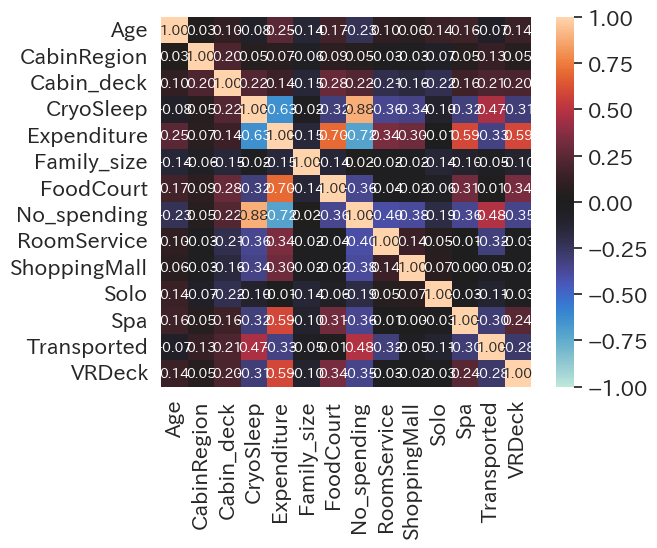

In [ ]:
sns.heatmap(peason, square=True, annot=True, fmt='.2f',annot_kws={'size':10},vmax=1, vmin=-1, center=0)

In [ ]:
#その他　object型をダミー変数変換
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

相互作用特徴量作成

相関係数の大きいもの同士を組み合わせた

In [ ]:
!pip install preproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_test = X_test.reset_index()

In [ ]:
import sklearn.preprocessing as preproc
from sklearn.preprocessing import PolynomialFeatures
features = ['Cabin_deck', 'FoodCourt']
X1 = X[features]
X2 = preproc.PolynomialFeatures(include_bias=False, interaction_only=True).fit_transform(X1)
X2 = pd.DataFrame(X2)
X2.drop([1, 2], axis=1, inplace=True)
X = pd.concat([X, X2], axis=1)
X.rename(columns={0: 'NoMove'}, inplace=True)

X_test1 = X_test[features]
X_test2 = preproc.PolynomialFeatures(include_bias=False, interaction_only=True).fit_transform(X_test1)
X_test2 = pd.DataFrame(X_test2)
X_test2.drop([1, 2], axis=1, inplace=True)
X_test = pd.concat([X_test, X_test2], axis=1)
X_test.rename(columns={0: 'NoMove'}, inplace=True)

相関係数

In [ ]:
from scipy.stats import pearsonr

peason = X.corr(method='pearson')
pr_corr_df = pd.DataFrame()
pr_corr_df = peason.round(decimals=3).astype(str)
pr_corr_df
pr_corr_df.sort_values(['Transported'], ascending=0)

Age CabinRegion Cabin_deck CryoSleep Expenditure Family_size  \
Transported   -0.075        0.13      0.209     0.467      -0.332      -0.051   
No_spending   -0.233        0.05      0.222     0.884      -0.717       0.019   
CryoSleep     -0.082        0.05      0.222       1.0      -0.634      -0.017   
Cabin_deck     0.102       0.205        1.0     0.222       0.143      -0.147   
NoMove         0.102       0.205        1.0     0.222       0.143      -0.147   
CabinRegion    0.028         1.0      0.205      0.05       0.065      -0.056   
FoodCourt      0.174       0.089      0.283    -0.315         0.7      -0.137   
Expenditure    0.248       0.065      0.143    -0.634         1.0      -0.153   
RoomService    0.095      -0.027     -0.209    -0.357       0.338      -0.023   
Spa            0.155       0.051      0.156    -0.317       0.593        -0.1   
VRDeck         0.136       0.053      0.197    -0.309        0.59      -0.103   
Solo           0.137      -0.071     -0.216    -0.099      -0.006      -0.139   
Age              1.0       0.028      0.102    -0.082       0.248      -0.135   
Family_size   -0.135      -0.056     -0.147    -0.017      -0.153         1.0   
ShoppingMall   0.064      -0.026     -0.158    -0.337       0.304      -0.017   

             FoodCourt No_spending RoomService ShoppingMall    Solo     Spa  \
Transported       0.01       0.483      -0.316        -0.05  -0.114    -0.3   
No_spending     -0.357         1.0      -0.404       -0.381  -0.187  -0.358   
CryoSleep       -0.315       0.884      -0.357       -0.337  -0.099  -0.317   
Cabin_deck       0.283       0.222      -0.209       -0.158  -0.216   0.156   
NoMove           0.283       0.222      -0.209       -0.158  -0.216   0.156   
CabinRegion      0.089        0.05      -0.027       -0.026  -0.071   0.051   
FoodCourt          1.0      -0.357      -0.037        -0.02  -0.062   0.312   
Expenditure        0.7      -0.717       0.338        0.304  -0.006   0.593   
RoomService     -0.037      -0.404         1.0        0.144   0.052  -0.006   
Spa              0.312      -0.358      -0.006        0.005  -0.031     1.0   
VRDeck           0.336      -0.349      -0.031       -0.024  -0.031   0.237   
Solo            -0.062      -0.187       0.052        0.072     1.0  -0.031   
Age              0.174      -0.233       0.095        0.064   0.137   0.155   
Family_size     -0.137       0.019      -0.023       -0.017  -0.139    -0.1   
ShoppingMall     -0.02      -0.381       0.144          1.0   0.072   0.005   

             Transported  VRDeck  NoMove  
Transported          1.0  -0.278   0.209  
No_spending        0.483  -0.349   0.222  
CryoSleep          0.467  -0.309   0.222  
Cabin_deck         0.209   0.197     1.0  
NoMove             0.209   0.197     1.0  
CabinRegion         0.13   0.053   0.205  
FoodCourt           0.01   0.336   0.283  
Expenditure       -0.332    0.59   0.143  
RoomService       -0.316  -0.031  -0.209  
Spa                 -0.3   0.237   0.156  
VRDeck            -0.278     1.0   0.197  
Solo              -0.114  -0.031  -0.216  
Age               -0.075   0.136   0.102  
Family_size       -0.051  -0.103  -0.147  
ShoppingMall       -0.05  -0.024  -0.158

Transported  の削除

In [ ]:
X.drop(['Transported'], axis=1, inplace=True)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)#特徴量Xたちを主成分分析

total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)
'''fig = px.scatter(
    components, x=0, y=1,color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title = f' Total Explained Variance分散説明率: {total_var: .2f}%',
    labels = {'0': 'PC 1', '1': 'PC 2'},
    width=800, height= 500
)
fig.show()'''

50.04410677013736


"fig = px.scatter(\n    components, x=0, y=1,color=y, size=0.1*np.ones(len(X)), opacity = 1,\n    title = f' Total Explained Variance分散説明率: {total_var: .2f}%',\n    labels = {'0': 'PC 1', '1': 'PC 2'},\n    width=800, height= 500\n)\nfig.show()"

In [ ]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pd.DataFrame(pca.components_.T, index=X.columns)
loadings.sort_values([0], ascending=0)

0         1         2
Solo          0.215051 -0.027199  0.627689
Expenditure   0.147846  0.310859 -0.082537
RoomService   0.124023  0.050645 -0.022647
ShoppingMall  0.096191  0.046833 -0.019454
Age           0.069316  0.312611  0.413598
Family_size   0.050419 -0.225564 -0.578067
Spa           0.038841  0.137707 -0.033200
VRDeck        0.030096  0.139985 -0.035436
FoodCourt     0.019368  0.178730 -0.039987
CabinRegion  -0.149917  0.185623 -0.063901
Cabin_deck   -0.455423  0.434772 -0.060102
NoMove       -0.455423  0.434772 -0.060102
CryoSleep    -0.471375 -0.343664  0.248705
No_spending  -0.487477 -0.384897  0.126334

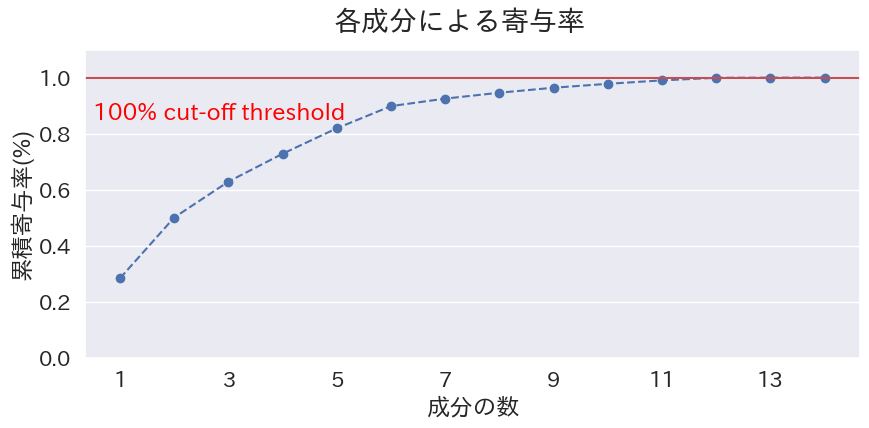

In [ ]:
from sklearn.decomposition import KernelPCA
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10, 4))
xi = np.arange(1, 1+X.shape[1], step=1)#x値: a.shape[0]はaの行(row)の数、a.shape[1]は列(col)の数、a.shape[2]はチャンネル数
yi = np.cumsum(pca.explained_variance_ratio_)#y値：pcaの各成分による寄与率
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0, 1.1)
plt.xlabel('成分の数')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))

plt.ylabel('累積寄与率(%)')
plt.suptitle('各成分による寄与率')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color='red')
ax.grid(axis='x')

In [ ]:
X_test.drop(['index'], axis=1, inplace=True)

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(X)
X = pca.transform(X)
X_test = pca.transform(X_test)

#**Create a validation set**
検証セットを作成\
これを使用して使用するモデルを選択する\
X:特徴量　y:ターゲット

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0)

#X_train, X_valid, y_train, y_valid = train_test_split(tester, y, stratify=y, train_size=0.8, test_size=0.2, random_state=0)

#**Model Selection**

**ロジスティック回帰:** \
最小二乗法を使用する線形回帰とは異なり、このモデルは最尤推定を使用して、ターゲット変数の分布にシグモイド曲線を当てはめます。 シグモイド/ロジスティック曲線は、データがバイナリ出力の質問である場合に一般的に使用されます。

**K 最近傍 (KNN):**\
 KNN は、k 最近傍の多数派クラスを選択することで機能します。ここで使用されるメトリックは通常、ユークリッド距離です。 これはシンプルで効果的なアルゴリズムですが、多くの要因によって影響を受ける可能性があります。 k の値、データに対して行われる前処理、および使用されるメトリック。

**サポート ベクター マシン (SVM):** \
SVM は、特徴空間内のデータを分離する最適な超平面を見つけます。 予測は、テスト ポイントが超平面のどちら側にあるかを調べることによって行われます。 通常の SVM は、データが線形分離可能であることを前提としていますが、常にそうであるとは限りません。 この仮定がデータを線形分離可能な高次元空間に変換できない場合は、カーネル トリックを使用できます。 SVM は、計算効率が高く、非常に優れた結果が得られるため、人気のあるアルゴリズムです。

**ランダム フォレスト (RF):**\
 RF は信頼性の高い決定木の集合であり、回帰または分類の問題に使用できます。 ここでは、個々のツリーはバギング (つまり、置換を伴うサンプリングによって作成された複数のトレーニング データセットに過ぎないブートストラップの集約) によって構築され、より少ない機能を使用して分割されます。 結果として得られる相関のない木の多様な森は、分散の減少を示します。 したがって、データの変化に対してより堅牢であり、その予測精度を新しいデータに伝えます。 連続データとカテゴリデータの両方でうまく機能します。

**Extreme Gradient Boosting (XGBoost):**\
 XGBoost は、決定木のアンサンブルで構成されているという点で RF に似ています。 違いは、これらのツリーがどのように派生したかで発生します。 XGboost は、目的関数を最適化するときに極端な勾配ブースティングを使用します。 多くの場合、最良の結果が得られますが、他の勾配ブースティング アルゴリズムに比べて比較的低速です。

**Light Gradient Boosting Machine (LGBM):**\
 LGBM は XGBoost と基本的に同じように機能しますが、より軽いブースティング手法を使用します。 通常、XGBoost と同様の結果が得られますが、大幅に高速です。

**Categorical Boosting (CatBoost):**\
 CatBoost は、勾配ブースト決定木に基づくオープン ソース アルゴリズムです。 数値、カテゴリ、およびテキスト機能をサポートしています。 異種データや比較的小さなデータでもうまく機能します。 非公式には、XGBoost と LGBM の両方の長所を取り入れようとしています。

**ナイーブ ベイズ (NB):** \
ナイーブ ベイズは、ベイズの定理を使用してサンプルを分類する方法を学習します。 事前情報を使用して、ベイズの法則に従ってこの情報を組み込むことにより、イベントの確率を「更新」します。 このアルゴリズムは非常に高速ですが、欠点は、入力フィーチャが独立していると仮定していることです。これは常にそうであるとは限りません。

これらのモデルをトレーニングし、検証セットで評価してから、次のクロス検証に持ち越すモデルを選択する。

In [ ]:
classifiers = {
    'LogisticRegression' : LogisticRegression(random_state=0), 
    'KNN' : KNeighborsClassifier(),
    'SVC' : SVC(random_state=0, probability=True), 
    'RandomForest' : RandomForestClassifier(random_state=0),
    'LGBM' : LGBMClassifier(random_state=0),
    'CatBoost' : CatBoostClassifier(random_state=0, verbose=False), 
    'NaiveBayes' : GaussianNB()
}
LR_grid = {'penalty': ['l1', 'l2'],
           'C' : [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter' : [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p' : [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
           'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

NB_grid = {'var_smooting': [1e-10, 1e-9, 1e-8, 1e-7]}

grid = {
    'LogisticRegression' : LR_grid,
    'KNN' : KNN_grid,
    'SVC' : SVC_grid,
    'RandomForest' : RF_grid,
    'XGBoost' : boosted_grid,
    'LGBM' : boosted_grid,
    'CatBoost' : boosted_grid,
    'NaiveBayes' : NB_grid
}

**モデルのトレーニングと評価**\
このデータセットに最適なモデルを大まかに把握するために、グリッド検索を使用してモデルをトレーニングする。

In [ ]:
i = 0
clf_best_params = classifiers
valid_scores = pd.DataFrame({'Classifer': classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})

for key, classifier in classifiers.items():
  start = time.time()
  clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

  clf.fit(X_train, y_train)
  valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)

  clf_best_params[key] = clf.best_params_

  stop = time.time()
  valid_scores.iloc[i, 2] = np.round((stop - start)/60, 2)
  
  print('Model', key)
  print('valid_scores', valid_scores.iloc[i, 1])
  print('Training time (mins)', valid_scores.iloc[i, 2])
  print('')

  i+=1

Model LogisticRegression
valid_scores 0.7550316273720529
Training time (mins) 0.06

Model KNN
valid_scores 0.7314548591144335
Training time (mins) 0.05

Model SVC
valid_scores 0.7602070155261644
Training time (mins) 27.66

Model RandomForest
valid_scores 0.7510063254744106
Training time (mins) 4.81

Model LGBM
valid_scores 0.7510063254744106
Training time (mins) 0.58

Model CatBoost
valid_scores 0.7515813686026452
Training time (mins) 17.6



ValueError: ignored

In [ ]:
valid_scores

Classifer  Validation accuracy  Training time
0  LogisticRegression             0.755032           0.16
1                 KNN             0.731455           0.10
2                 SVC             0.760207          24.22
3        RandomForest             0.751006           4.80
4                LGBM             0.751006           0.59
5            CatBoost             0.751581          17.04
6          NaiveBayes             0.000000           0.00

これをきっかけにLGBMとCatBoostをモデリングの最終段階に進める。

グリッドサーチから最適なパラメータを表示

In [ ]:
clf_best_params

{'LogisticRegression': {'C': 1.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'SVC': {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 8, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200},
 'NaiveBayes': GaussianNB()}

#**Modelling**

最終的に、相互検証とアンサンブル予測を一緒に使用し、Training set全体で最良のモデルをトレーニングし、最も信頼性の高い予測を生成する。


**最良モデルの定義**

In [ ]:
y = y.to_numpy()

In [ ]:
best_classifiers = {
    'LGBM' : LGBMClassifier(**clf_best_params['LGBM'], random_state=0),
    'SVC' : SVC(**clf_best_params['SVC'], random_state=0, probability=True),
}
'''
best_classifiers = {
  'CatBoost' : CatBoostClassifier(**clf_best_params['CatBoost'], verbose=False, random_state=0)
    'LogisticRegression' : LogisticRegression(**clf_best_params['LogisticRegression'], random_state=0), 
    'SVC' : SVC(**clf_best_params['SVC'], random_state=0, probability=True)
}'''

"\nbest_classifiers = {\n  'CatBoost' : CatBoostClassifier(**clf_best_params['CatBoost'], verbose=False, random_state=0)\n    'LogisticRegression' : LogisticRegression(**clf_best_params['LogisticRegression'], random_state=0), \n    'SVC' : SVC(**clf_best_params['SVC'], random_state=0, probability=True)\n}"

**交差検証とアンサンブル予測**\
予測はソフト投票を使用して組み立てられる。\
これにより、予測確率が平均化され最も信頼できる予測が生成される。\
X=訓練特徴量で訓練データと検証データに分ける

In [ ]:
X_test = pd.DataFrame(X_test)

In [ ]:
X_test = X_test.to_numpy()

In [ ]:
FOLDS = 10
preds = np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
  start = time.time()

  cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)#層化ｋ分割交差検証

  score = 0
  for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_idx], X[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]

    clf = classifier#LGBMとSVC
    clf.fit(X_train, y_train)

    preds += clf.predict_proba(X_test)[:, 1]
    score += clf.score(X_valid, y_valid)

  score = score/FOLDS

  stop = time.time()

  print('Model', key)
  print('Average validation accuracy平均検証精度', np.round(100*score, 2))
  print('Training time(min)', np.round((stop - start)/60, 2))

preds = preds / (FOLDS * len(best_classifiers))

Model LGBM
Average validation accuracy平均検証精度 76.39
Training time(min) 0.04
Model SVC
Average validation accuracy平均検証精度 75.53
Training time(min) 2.97


学習曲線
バイアスとバリアンスの問題を診断

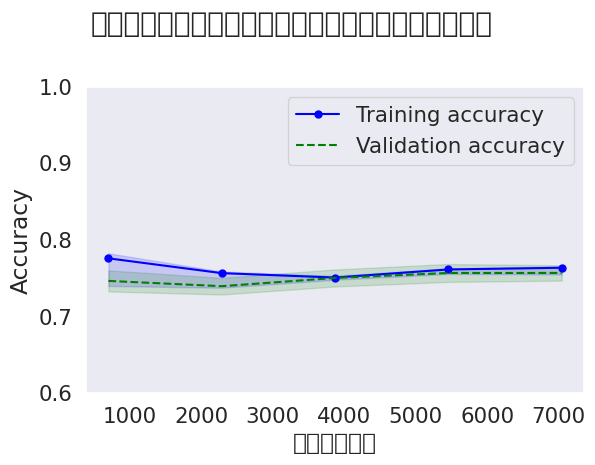

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=X_train, y=y_train, cv=cv)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, test_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('訓練データ数')
plt.ylabel('Accuracy')
plt.suptitle('学習曲線を使ってバイアスとバリアンスの問題を診断')
plt.legend(loc='best')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()

検証曲線
過学習と学習不足を明らかにする

In [ ]:
print(clf)

SVC(C=1.5, probability=True, random_state=0)


In [ ]:
clf.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

[[0.58883681 0.60034086 0.5972163  0.58642238 0.60110764 0.58477705
  0.59741551 0.60778188 0.58236297 0.59698949]
 [0.73782133 0.73909956 0.73938361 0.73853146 0.73800057 0.73729054
  0.73785856 0.74112468 0.73658052 0.73714854]
 [0.74378639 0.74236614 0.74350234 0.74350234 0.74226072 0.74098268
  0.74240273 0.74495882 0.74140869 0.7415507 ]
 [0.78383752 0.78199119 0.78156512 0.78383752 0.78173814 0.78429423
  0.78528827 0.78528827 0.78188015 0.78543028]
 [0.81153245 0.80997017 0.81309473 0.81139043 0.80857711 0.81198523
  0.81425731 0.81084919 0.81155922 0.81368929]]


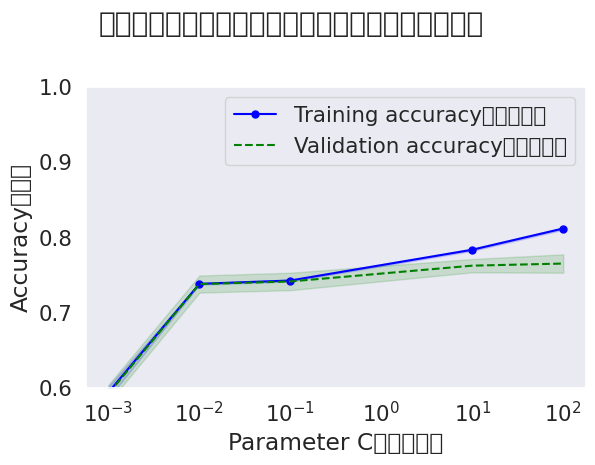

In [ ]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, y=y_train, cv=cv, param_name='C', param_range=param_range)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_scores)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy訓練正解率')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', markersize=5, label='Validation accuracy検証正解率')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.suptitle('検証曲線を使って過学習と学習不足を明らかにする')
plt.xlabel('Parameter Cパラメータ')
plt.ylabel('Accuracy正解率')
plt.xscale('log')
plt.legend(loc='best')
plt.ylim([0.6, 1.0])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

model_1 = LGBMClassifier(**clf_best_params['LGBM'], random_state=0)
model_2 = SVC(**clf_best_params['SVC'], random_state=0, probability=True)
model_3 = LogisticRegression(**clf_best_params['LogisticRegression'], random_state=0)

pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

first_pred_1 = model_1.predict(X_valid)
first_pred_2 = model_2.predict(X_valid)
first_pred_3 = model_3.predict(X_valid)

stack_pred = np.column_stack((first_pred_1, first_pred_2, first_pred_3))

meta_model = LinearRegression()
meta_model.fit(stack_pred, y_valid)

stack_test_pred = np.column_stack((pred_1, pred_2, pred_3))
meta_test_pred = meta_model.predict(stack_test_pred)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

from models import Model1Xgb, Model1NN, Model2Linear

def predict_cv(model, X_train, y_train, test_x):
  preds = []
  preds_test = []
  va_idxes = []

  df = KFold(n_splits=4, shuffle=True, random_state=71)

  for i, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    model.fit(tr_x, tr_y, va_x, va_y)
    pre = model.predict(va_x)
    pred.append(pred)
    pred_test = model.predict(test_x)
    pred_test.append(pred_test)
    va_idxis.append(va_idx)

    va_idxes = np.concatenate(va_idxes)
    or

# **Submission**
予測確率の分布を見てみる

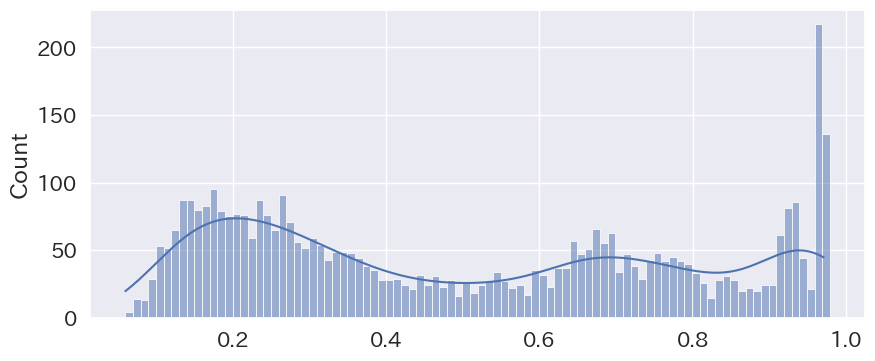

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title = ('Predicted probabilities')
plt.xlabel = ('Probability')

モデルが非常に自信があるか、非常に自信がないかのどちらかであるが、その中間ではない。

**後処理**\
最後に各予測確率を2つのクラス（輸送されるかどうか）のいずれかに変換する必要がある。\
最も簡単な方法は、各確率を最も近い整数（False=0, True=1)に丸めること。\
ただし、訓練セットとテストセットの分布が類似していると仮定すると、分類閾値を調整して、予測で訓練セットと同様の輸送/非輸送の割合を取得できる。\
訓練セットで輸送された乗車の割合が50.4%だったことを思い出してほしい

In [ ]:
print(np.round(100*np.round(preds).sum()/len(preds), 2))

47.86


私たちのモデルは潜在的にテストセット内の輸送された乗客の数を過大評価しているようだ。その比率を少し下げる。

Optimal threshold 0.43


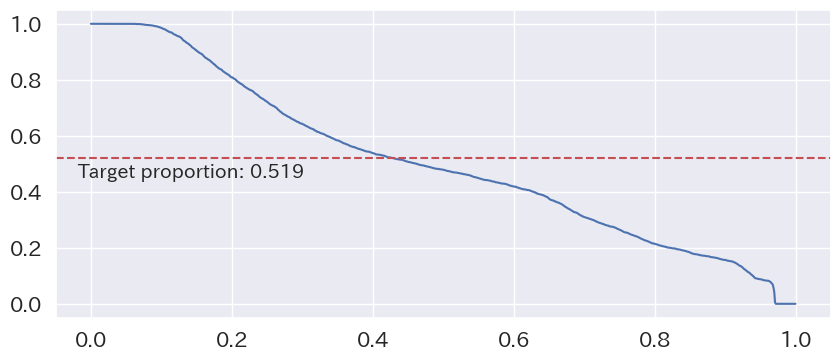

In [ ]:
def preds_prop(preds_arr, thresh):
  pred_classes = (preds_arr >= thresh).astype(int)
  return pred_classes.sum() / len(pred_classes)

def plot_preds_prop(preds_arr):
  T_array = np.arange(0, 1, 0.001)

  prop = np.zeros(len(T_array))
  for i, T in enumerate(T_array):
    prop[i] = preds_prop(preds_arr, T)
  
  plt.figure(figsize=(10, 4))
  plt.plot(T_array, prop)
  target_prop = 0.519
  plt.axhline(y=target_prop, color='r', linestyle='--')
  plt.text(-0.02, 0.45, f'Target proportion: {target_prop}', fontsize=14)
  plt.title = ('Predicted target distribution vs threshold')
  plt.xlabel = ('Threshold')
  plt.ylabel = ('Proportion')

  T_opt = T_array[np.abs(prop-target_prop).argmin()]
  print('Optimal threshold', T_opt)
  return T_opt

T_opt = plot_preds_prop(preds)

In [ ]:
preds_tuned=(preds>=T_opt).astype(int)

#**SUBMIT Predictions**


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spaceship/sample_submission.csv')
sub['Transported'] = preds_tuned

sub = sub.replace({0:False, 1:True})

plt.figure(figsize=(6, 6))
#sub['Transported'].value_counts().plt.pie(explode=[0.1, 0.1], autopct='%1.1f%%', textprops={'fontsize':16}).set_title('Prediction distribution')


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [ ]:
sub.to_csv('submission.csv', index=False)